# Vigil: Trader Intelligence Analysis

Deep dive into Hyperliquid trader behavior using the SQL analytics pipeline.

## Setup
```bash
just db-local-up && just db-local-migrate
just cloud-sample && just local-load
just db-local-aggregates && just db-local-refresh
```

In [29]:
import os
import polars as pl
import numpy as np
import psycopg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Database connection
url = os.getenv('DATABASE_URL')
conn = psycopg.connect(url)

def query(sql: str) -> pl.DataFrame:
    """Execute SQL and return as Polars DataFrame."""
    with conn.cursor() as cur:
        cur.execute(sql)
        cols = [d[0] for d in cur.description]
        rows = cur.fetchall()
        return pl.DataFrame(rows, schema=cols, orient="row")

print("Databse Connected!")

Databse Connected!


---
## 1. Data Overview

High-level stats on the fills dataset.

In [30]:
# Overall fills summary (using trader_profiles materialized view)
query("""
    SELECT 
        SUM(total_fills)::bigint as total_fills,
        COUNT(*) as unique_traders,
        MAX(unique_coins) as unique_coins,
        ROUND(SUM(total_volume)::numeric, 2) as total_volume_usd,
        ROUND(SUM(realized_pnl)::numeric, 2) as total_realized_pnl,
        ROUND(SUM(fees_paid)::numeric, 2) as total_fees
    FROM trader_profiles
""")

total_fills,unique_traders,unique_coins,total_volume_usd,total_realized_pnl,total_fees
i64,i64,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]"
960561768,467189,189,2754713732085.11,-400235627.76,3127034384.38


In [31]:
# Time range of data (using trader_profiles materialized view)
query("""
    SELECT 
        MIN(first_trade_time) as first_fill,
        MAX(last_trade_time) as last_fill,
        ROUND(((MAX(last_trade_time) - MIN(first_trade_time)) / 86400000.0)::numeric, 1) as days_of_data
    FROM trader_profiles
""")

first_fill,last_fill,days_of_data
i64,i64,"decimal[38,1]"
1753574400000,1764547200000,127.0


In [32]:
# Maker vs Taker breakdown (using trader_daily continuous aggregate)
query("""
    SELECT 
        'Maker' as side,
        SUM(maker_fills)::bigint as fills,
        ROUND(SUM(maker_fills)::numeric / NULLIF(SUM(fill_count), 0) * 100, 1) as pct
    FROM trader_daily
    UNION ALL
    SELECT 
        'Taker' as side,
        SUM(taker_fills)::bigint as fills,
        ROUND(SUM(taker_fills)::numeric / NULLIF(SUM(fill_count), 0) * 100, 1) as pct
    FROM trader_daily
    ORDER BY fills DESC
""")

side,fills,pct
str,i64,"decimal[38,1]"
"""Taker""",480548868,50.0
"""Maker""",480012900,50.0


---
## 2. Trader Classification Analysis

Breakdown by trader type: HFT, Smart Directional, Liquidator, Retail.

**Classification Criteria:**
- **LIQUIDATOR**: ≥20% of fills are liquidations
- **HFT**: ≥70% maker, ≤10bps edge (MTM/TV)
- **SMART_DIRECTIONAL**: ≥$100K PnL, ≥10bps edge, ≥1.0 Sharpe
- **RETAIL**: Everyone else

In [33]:
# Trader type distribution
query("SELECT * FROM top_traders_by_type")

trader_type,trader_count,total_volume,total_pnl,avg_sharpe,avg_maker_pct
str,i64,"decimal[38,17]","decimal[38,10]",f64,"decimal[38,24]"
"""RETAIL""",412539,1778466837547.91377114701324219,-5639709695.3675027892,-2.342756,0.107284271276194131895379
"""HFT""",11570,667210807979.02491768191479550,-65713216.8825568278,-0.645102,0.922382881308475351100000
"""SMART_DIRECTIONAL""",1773,296803940778.78612645776312179,2301146299.1037836703,7.275521,0.341794352220836232211880
"""LIQUIDATOR""",41307,12232145779.38955050728919270,-157250886.4009583440,-10.849411,0.082019036445612684271140


In [34]:
# Detailed breakdown by trader type
type_stats = query("""
    SELECT 
        trader_type,
        COUNT(*) as num_traders,
        ROUND(AVG(total_fills)::numeric, 0) as avg_trades,
        ROUND(AVG(total_volume)::numeric, 0) as avg_volume,
        ROUND(SUM(total_volume)::numeric, 0) as total_volume,
        ROUND(SUM(net_pnl)::numeric, 2) as total_pnl,
        ROUND(AVG(net_pnl)::numeric, 2) as avg_pnl,
        ROUND(AVG(maker_pct) * 100, 1) as avg_maker_pct,
        ROUND(AVG(win_rate) * 100, 1) as avg_win_rate,
        ROUND(AVG(mtm_tv) * 10000, 2) as avg_edge_bps
    FROM trader_profiles
    GROUP BY trader_type
    ORDER BY total_pnl DESC
""")
type_stats

trader_type,num_traders,avg_trades,avg_volume,total_volume,total_pnl,avg_pnl,avg_maker_pct,avg_win_rate,avg_edge_bps
str,i64,"decimal[38,0]","decimal[38,0]","decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,1]","decimal[38,2]"
"""SMART_DIRECTIONAL""",1773,73264,167402110,296803940779,2301146299.10,1297882.85,34.2,68.6,649.57
"""HFT""",11570,22870,57667313,667210807979,-65713216.88,-5679.62,92.2,51.0,0.40
"""LIQUIDATOR""",41307,36,296128,12232145779,-157250886.40,-3806.88,8.2,17.8,-786.63
"""RETAIL""",412539,1369,4311027,1778466837548,-5639709695.37,-13670.73,10.7,47.4,-5590.97


In [35]:
# Volume share by trader type
if len(type_stats) > 0:
    type_stats.with_columns(
        (pl.col("total_volume").cast(pl.Float64) / pl.col("total_volume").cast(pl.Float64).sum() * 100).round(1).alias("volume_share_pct")
    ).select(["trader_type", "num_traders", "total_volume", "volume_share_pct", "total_pnl"])
else:
    print("No trader profiles found")

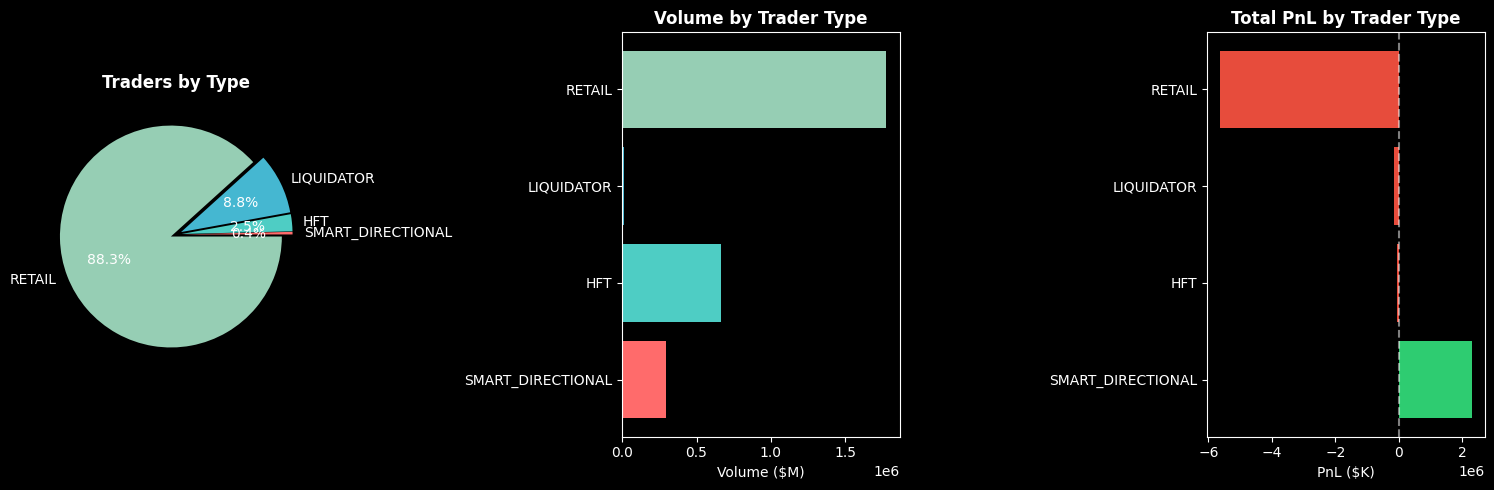

In [36]:
# Visualization: Trader Type Distribution
if len(type_stats) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Pie chart - number of traders
    traders = type_stats['num_traders'].to_list()
    labels = type_stats['trader_type'].to_list()
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'][:len(labels)]
    
    axes[0].pie(traders, labels=labels, autopct='%1.1f%%', colors=colors, explode=[0.05]*len(labels))
    axes[0].set_title('Traders by Type', fontsize=12, fontweight='bold')
    
    # Bar chart - volume by type
    volumes = [float(v) for v in type_stats['total_volume'].to_list()]
    axes[1].barh(labels, [v/1e6 for v in volumes], color=colors)
    axes[1].set_xlabel('Volume ($M)')
    axes[1].set_title('Volume by Trader Type', fontsize=12, fontweight='bold')
    
    # Bar chart - PnL by type
    pnls = [float(p) for p in type_stats['total_pnl'].to_list()]
    colors_pnl = ['#2ecc71' if p > 0 else '#e74c3c' for p in pnls]
    axes[2].barh(labels, [p/1000 for p in pnls], color=colors_pnl)
    axes[2].set_xlabel('PnL ($K)')
    axes[2].set_title('Total PnL by Trader Type', fontsize=12, fontweight='bold')
    axes[2].axvline(x=0, color='white', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

---
## 3. Top Performers Analysis

Who's making money and how?

In [37]:
# Top 20 profitable traders
top_winners = query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(maker_pct * 100, 1) as maker_pct,
        ROUND(win_rate * 100, 1) as win_rate,
        ROUND(mtm_tv * 10000, 2) as edge_bps,
        ROUND(sharpe_ratio::numeric, 2) as sharpe
    FROM trader_profiles
    ORDER BY net_pnl DESC
    LIMIT 20
""")
top_winners

user_address,trader_type,trades,volume,net_pnl,maker_pct,win_rate,edge_bps,sharpe
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,1]","decimal[38,2]","decimal[38,2]"
"""0x2ea18c23f72a4b6172c55b411823…","""SMART_DIRECTIONAL""",175088,2139885707.60,106650801.80,10.4,59.6,500.98,11.02
"""0xb317d2bc2d3d2df5fa441b5bae0a…","""SMART_DIRECTIONAL""",120701,3556427930.99,101167760.30,27.4,97.7,286.63,5.50
"""0x7fdafde5cfb5465924316eced2d3…","""SMART_DIRECTIONAL""",1658398,3383404060.17,73965365.77,60.0,58.6,219.24,3.33
"""0x5b5d51203a0f9079f8aeb098a652…","""SMART_DIRECTIONAL""",1039142,2213565921.91,66023950.03,9.7,62.7,300.37,2.21
"""0xb83de012dba672c76a7dbbbf3e45…","""SMART_DIRECTIONAL""",795111,2118978950.04,59551412.43,9.5,69.3,283.40,1.90
…,…,…,…,…,…,…,…,…
"""0xfa6af5f4f7440ce389a1e650991e…","""SMART_DIRECTIONAL""",19590,451241124.33,20244865.60,6.2,99.9,450.98,5.29
"""0xd5ff5491f6f3c80438e02c281726…","""SMART_DIRECTIONAL""",27454,615953114.62,19863253.85,10.6,82.5,324.31,1.86
"""0xd47587702a91731dc1089b5db093…","""SMART_DIRECTIONAL""",929444,2274469087.06,18913729.40,49.0,52.9,85.75,1.57


In [38]:
# Biggest losers (potential counter-signals)
query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(maker_pct * 100, 1) as maker_pct,
        ROUND(win_rate * 100, 1) as win_rate
    FROM trader_profiles
    ORDER BY net_pnl ASC
    LIMIT 20
""")

user_address,trader_type,trades,volume,net_pnl,maker_pct,win_rate
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,1]"
"""0x87fd3014c75b85c80b64feabd5ea…","""RETAIL""",875,763463.11,-670666373.51,95.8,27.9
"""0xe5350e927b904fdb4d2af55c566e…","""RETAIL""",970,2176977.84,-397801738.99,33.2,16.4
"""0x9d9ce79e6f13f4deb989a022cab1…","""RETAIL""",182,320325.59,-311795408.02,48.4,56.8
"""0x1f876d9252596fcaf8d651a6f443…","""RETAIL""",29,71989.47,-132904405.93,6.9,84.2
"""0xabdc1406b2cc155f985f4ad1f8fb…","""RETAIL""",414,193721.42,-117701258.16,37.0,33.6
…,…,…,…,…,…,…
"""0x01ae350a6ecc39399c88eb3e4ac2…","""RETAIL""",4581,3382102.38,-26456417.38,100.0,50.9
"""0x7b7f72a28fe109fa703eeed7984f…","""HFT""",3395099,45572899078.86,-23242091.77,74.1,47.1
"""0x5028826c24d903e21f680da5b413…","""RETAIL""",588,92851.40,-22524642.50,98.3,0.0


In [39]:
# Most active traders by volume
query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(mtm_tv * 10000, 2) as edge_bps
    FROM trader_profiles
    ORDER BY total_volume DESC
    LIMIT 20
""")

user_address,trader_type,trades,volume,net_pnl,edge_bps
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""0xc6ac58a7a63339898aeda32499a8…","""RETAIL""",3630936,85206176501.99,-4625059.92,0.15
"""0xe3b6e3443c8f2080704e7421bad9…","""RETAIL""",1929182,67952478637.12,-5699066.98,-0.42
"""0xecb63caa47c7c4e77f60f1ce858c…","""SMART_DIRECTIONAL""",23947881,61464324830.84,30702482.59,14.78
"""0x162cc7c861ebd0c06b3d72319201…","""RETAIL""",19131989,49300314742.74,-50707956.10,1.09
"""0x023a3d058020fb76cca98f01b3c4…","""HFT""",9276073,48589608981.72,28994046.26,4.94
…,…,…,…,…,…
"""0x53babe76166eae33c861aeddf9ce…","""RETAIL""",934463,21853581002.07,-3485554.14,0.32
"""0xee162a5a60829bd346f0c1ac3514…","""RETAIL""",12150493,19702353567.40,-921534.93,0.09
"""0x49ba9baa20d355ba042af2be9772…","""RETAIL""",969133,17930344842.33,841714.31,0.53


---
## 4. Edge Analysis (MTM/TV)

**MTM/TV = Mark-to-Market / Trading Volume**

This is the key metric for distinguishing trader types:
- **< 10 bps**: Likely market maker (profits from spread, not direction)
- **> 10 bps**: Directional trader (profits from price moves)

Higher edge = more skilled directional trader.

In [40]:
# Edge distribution by trader type
query("""
    SELECT 
        trader_type,
        ROUND((MIN(mtm_tv) * 10000)::numeric, 2) as min_edge_bps,
        ROUND((PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY mtm_tv) * 10000)::numeric, 2) as p25_edge_bps,
        ROUND((PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY mtm_tv) * 10000)::numeric, 2) as median_edge_bps,
        ROUND((PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY mtm_tv) * 10000)::numeric, 2) as p75_edge_bps,
        ROUND((MAX(mtm_tv) * 10000)::numeric, 2) as max_edge_bps
    FROM trader_profiles
    WHERE total_volume > 10000  -- Filter noise
    GROUP BY trader_type
    ORDER BY median_edge_bps DESC
""")

trader_type,min_edge_bps,p25_edge_bps,median_edge_bps,p75_edge_bps,max_edge_bps
str,"decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""SMART_DIRECTIONAL""",10.14,57.34,216.03,628.61,9983.21
"""HFT""",-9.97,-2.09,0.00,4.45,9.99
"""RETAIL""",-2424130.10,-36.24,-4.67,5.89,21952.67
"""LIQUIDATOR""",-84009.80,-385.61,-137.57,-50.52,22703.07


In [41]:
# High-edge traders (skilled directional)
query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(mtm_tv * 10000, 2) as edge_bps,
        ROUND(win_rate * 100, 1) as win_rate
    FROM trader_profiles
    WHERE total_volume > 100000  -- Meaningful volume
    ORDER BY mtm_tv DESC
    LIMIT 20
""")

user_address,trader_type,trades,volume,net_pnl,edge_bps,win_rate
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,1]"
"""0xa3b69fd03a59945b88fed1fe350b…","""RETAIL""",76,165945.09,364246.01,21952.67,100.0
"""0xde97bba2f73845bfb3dc28fd4886…","""LIQUIDATOR""",1,202845.30,312625.81,15412.03,100.0
"""0x22b9a3617a83d92a6977dafeb1d2…","""RETAIL""",1795,163339.74,209742.09,12845.35,100.0
"""0xd27c53926551d39d2e8dd352e073…","""RETAIL""",186,106622.37,114567.73,10749.49,100.0
"""0x6c6756b7874b8f73b9fa937e0452…","""RETAIL""",25,122670.41,122623.28,10000.00,100.0
…,…,…,…,…,…,…
"""0x5766fabeba5aa4071a3e79f23dc3…","""SMART_DIRECTIONAL""",158,915567.97,830550.28,9077.19,100.0
"""0xcff5de8bf37966a9942e4337a8e1…","""SMART_DIRECTIONAL""",71,171744.40,155354.19,9049.55,98.6
"""0x588f6ccb39f3d474c5b373648358…","""RETAIL""",15,110000.96,97848.89,8902.28,100.0


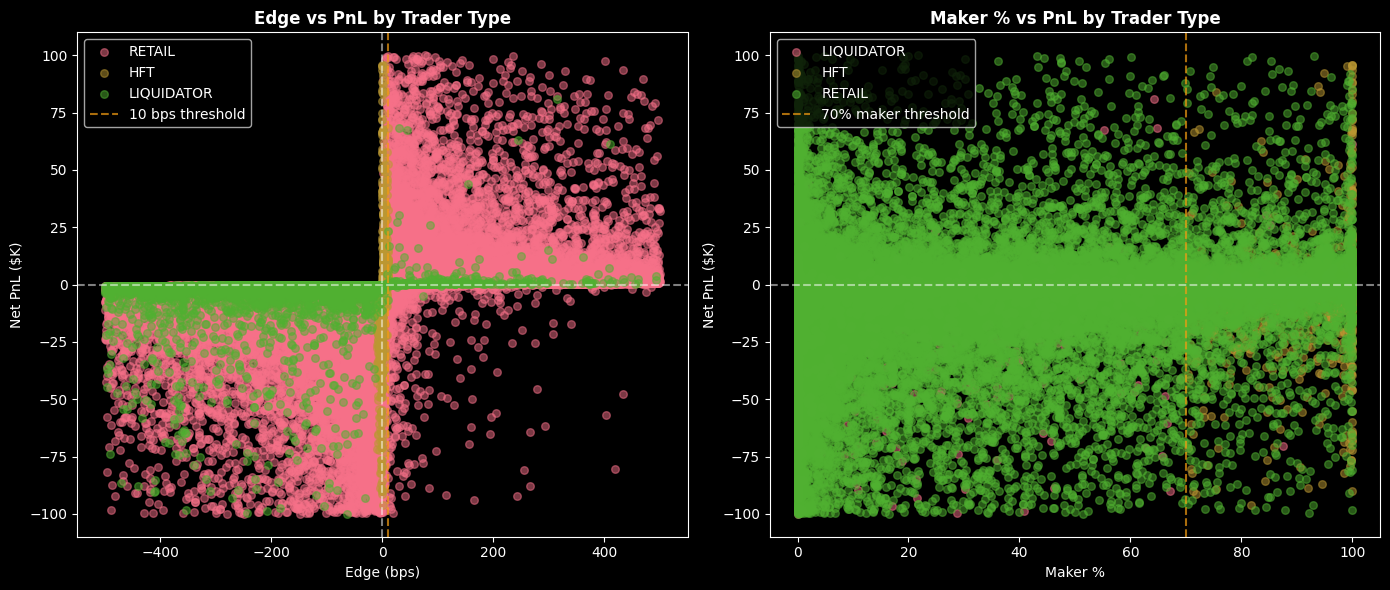

In [42]:
# Visualization: Edge vs PnL Scatter Plot
scatter_data = query("""
    SELECT 
        trader_type,
        mtm_tv * 10000 as edge_bps,
        net_pnl,
        total_volume,
        maker_pct * 100 as maker_pct
    FROM trader_profiles
    WHERE total_volume > 10000
      AND ABS(mtm_tv * 10000) < 500  -- Filter extreme outliers
      AND ABS(net_pnl) < 100000
""")

if len(scatter_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Edge vs PnL colored by trader type
    for ttype in scatter_data['trader_type'].unique().to_list():
        subset = scatter_data.filter(pl.col('trader_type') == ttype)
        edge = [float(e) for e in subset['edge_bps'].to_list()]
        pnl = [float(p)/1000 for p in subset['net_pnl'].to_list()]
        axes[0].scatter(edge, pnl, alpha=0.5, label=ttype, s=30)
    
    axes[0].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    axes[0].axvline(x=0, color='white', linestyle='--', alpha=0.5)
    axes[0].axvline(x=10, color='#f39c12', linestyle='--', alpha=0.7, label='10 bps threshold')
    axes[0].set_xlabel('Edge (bps)')
    axes[0].set_ylabel('Net PnL ($K)')
    axes[0].set_title('Edge vs PnL by Trader Type', fontsize=12, fontweight='bold')
    axes[0].legend(loc='upper left')
    
    # Maker % vs PnL
    for ttype in scatter_data['trader_type'].unique().to_list():
        subset = scatter_data.filter(pl.col('trader_type') == ttype)
        maker = [float(m) for m in subset['maker_pct'].to_list()]
        pnl = [float(p)/1000 for p in subset['net_pnl'].to_list()]
        axes[1].scatter(maker, pnl, alpha=0.5, label=ttype, s=30)
    
    axes[1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    axes[1].axvline(x=70, color='#f39c12', linestyle='--', alpha=0.7, label='70% maker threshold')
    axes[1].set_xlabel('Maker %')
    axes[1].set_ylabel('Net PnL ($K)')
    axes[1].set_title('Maker % vs PnL by Trader Type', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

---
## 5. HFT / Market Maker Analysis

Characteristics:
- High maker % (≥70%)
- Low edge per trade (≤10 bps)
- High turnover
- Profits from rebates and spread capture

In [43]:
# HFT traders ranked by volume
hft_traders = query("""
    SELECT 
        user_address,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(maker_pct * 100, 1) as maker_pct,
        ROUND(mtm_tv * 10000, 4) as edge_bps,
        ROUND(fees_paid::numeric, 2) as fees
    FROM trader_profiles
    WHERE trader_type = 'HFT'
    ORDER BY total_volume DESC
    LIMIT 20
""")
hft_traders

user_address,trades,volume,net_pnl,maker_pct,edge_bps,fees
str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,4]","decimal[38,2]"
"""0x023a3d058020fb76cca98f01b3c4…",9276073,48589608981.72,28994046.26,97.1,4.9371,-5005049.66
"""0x7b7f72a28fe109fa703eeed7984f…",3395099,45572899078.86,-23242091.77,74.1,-5.3384,-1086514.08
"""0xf9109ada2f73c62e9889b4545306…",6336953,39619325710.71,-4892287.24,79.8,-1.3443,-433908.09
"""0x57dd78cd36e76e2011e8f6dc25ca…",7614861,30117484715.08,-16030028.26,87.6,-5.4583,-409024.72
"""0x39475d17bcd20adc540e647dae67…",643557,15553778665.64,2099879.80,90.5,1.0882,-407252.51
…,…,…,…,…,…,…
"""0xaf9f722a676230cc44045efe26fe…",340113,7405854738.43,-2787834.92,76.2,-3.8507,-63949.69
"""0xadc9cf23f55c6221a05a8150e576…",357847,7006764091.15,739726.33,100.0,0.7557,-210202.75
"""0x95995f302ad58138d791ce49f9f3…",265445,6976972085.44,1296723.72,98.2,1.5716,-200188.35


In [44]:
# HFT stats summary
if len(hft_traders) > 0:
    hft_traders.select([
        pl.col("trades").cast(pl.Float64).sum().alias("total_trades"),
        pl.col("volume").cast(pl.Float64).sum().alias("total_volume"),
        pl.col("net_pnl").cast(pl.Float64).sum().alias("total_pnl"),
        pl.col("maker_pct").cast(pl.Float64).mean().round(1).alias("avg_maker_pct"),
        pl.col("edge_bps").cast(pl.Float64).mean().round(2).alias("avg_edge_bps"),
    ])
else:
    print("No HFT traders found")

---
## 6. Smart Directional Traders

The signal we care about most:
- High PnL (≥$100K)
- High edge (≥10 bps)
- Good Sharpe (≥1.0)

These traders make money from **knowing direction**, not from spreads.

In [45]:
# Smart directional traders
smart_traders = query("""
    SELECT 
        user_address,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(mtm_tv * 10000, 2) as edge_bps,
        ROUND(win_rate * 100, 1) as win_rate,
        ROUND(sharpe_ratio::numeric, 2) as sharpe,
        ROUND(maker_pct * 100, 1) as maker_pct
    FROM trader_profiles
    WHERE trader_type = 'SMART_DIRECTIONAL'
    ORDER BY net_pnl DESC
    LIMIT 30
""")
smart_traders

user_address,trades,volume,net_pnl,edge_bps,win_rate,sharpe,maker_pct
str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,2]","decimal[38,1]"
"""0x2ea18c23f72a4b6172c55b411823…",175088,2139885707.60,106650801.80,500.98,59.6,11.02,10.4
"""0xb317d2bc2d3d2df5fa441b5bae0a…",120701,3556427930.99,101167760.30,286.63,97.7,5.50,27.4
"""0x7fdafde5cfb5465924316eced2d3…",1658398,3383404060.17,73965365.77,219.24,58.6,3.33,60.0
"""0x5b5d51203a0f9079f8aeb098a652…",1039142,2213565921.91,66023950.03,300.37,62.7,2.21,9.7
"""0xb83de012dba672c76a7dbbbf3e45…",795111,2118978950.04,59551412.43,283.40,69.3,1.90,9.5
…,…,…,…,…,…,…,…
"""0x1c020f03305acd09994c1910d440…",150237,149795009.71,15430177.84,1032.69,38.1,3.67,0.7
"""0xb9c0283968744b80aef904455bb3…",10673,60049017.83,15214585.78,2536.27,93.9,9.22,1.8
"""0x091159a8106b077c13e89bc09701…",2072,94142953.55,14945106.41,1590.10,100.0,11.83,0.1


In [46]:
# Smart trader behavior patterns
if len(smart_traders) > 0:
    # Cast decimal columns to float for Polars aggregations
    smart_traders.select([
        pl.len().alias("count"),
        pl.col("trades").cast(pl.Float64).mean().round(0).alias("avg_trades"),
        pl.col("volume").cast(pl.Float64).mean().round(0).alias("avg_volume"),
        pl.col("net_pnl").cast(pl.Float64).mean().round(2).alias("avg_pnl"),
        pl.col("edge_bps").cast(pl.Float64).mean().round(2).alias("avg_edge_bps"),
        pl.col("win_rate").cast(pl.Float64).mean().round(1).alias("avg_win_rate"),
        pl.col("sharpe").cast(pl.Float64).mean().round(2).alias("avg_sharpe"),
    ])
else:
    print("No SMART_DIRECTIONAL traders found")

---
## 7. Liquidator Analysis

Traders who primarily execute liquidations. These are often bots that:
- Monitor positions approaching liquidation
- Execute liquidation transactions for profit

In [47]:
# Top liquidators
query("""
    SELECT 
        user_address,
        total_fills as trades,
        liquidation_fills as liq_trades,
        ROUND(liquidation_pct * 100, 1) as liq_pct,
        ROUND(liquidation_volume::numeric, 2) as liq_volume,
        ROUND(net_pnl::numeric, 2) as net_pnl
    FROM trader_profiles
    WHERE trader_type = 'LIQUIDATOR'
    ORDER BY liquidation_volume DESC
    LIMIT 20
""")

user_address,trades,liq_trades,liq_pct,liq_volume,net_pnl
str,"decimal[38,0]","decimal[38,0]","decimal[38,1]","decimal[38,2]","decimal[38,2]"
"""0xb0a55f13d22f66e6d495ac981138…",48619,12369,25.4,2864202845.50,17237158.34
"""0x916ea2a9f3ba1ddd006c52babd02…",19601,4946,25.2,220646195.27,-2640212.41
"""0x8c20e0eddfee07ed6b97c7752b99…",10285,2917,28.4,128908312.42,-207522.02
"""0xb45a50dac3d8115321fe6e80efd3…",10905,2454,22.5,120873417.57,-1933738.01
"""0x93c5753e47ae857c372fc2ebaa5f…",49568,10398,21.0,109649157.65,-4583982.90
…,…,…,…,…,…
"""0xfff0780db25c29d7b9936dd46a90…",5828,1467,25.2,31195533.92,-1782153.53
"""0x51e15a70464d7639961592e1f07e…",1347,1337,99.3,29963938.49,-2035271.00
"""0xd6f52e2ab58a678eced4a4d16937…",4271,866,20.3,29670756.07,-838027.82


In [48]:
# Recent liquidation events (last 7 days only for performance)
# Note: liquidation column is stored as escaped JSON string
query("""
    SELECT 
        to_timestamp(time/1000) as ts,
        user_address as liquidator,
        coin,
        px as price,
        sz as size,
        ROUND((px::numeric * sz::numeric)::numeric, 2) as notional,
        REPLACE(TRIM(BOTH '"' FROM liquidation), '""', '"')::json->>'liquidatedUser' as liquidated_user,
        REPLACE(TRIM(BOTH '"' FROM liquidation), '""', '"')::json->>'method' as method
    FROM fills
    WHERE liquidation IS NOT NULL 
      AND liquidation <> ''
      AND time > (EXTRACT(EPOCH FROM NOW()) * 1000 - 7 * 86400000)::bigint
    ORDER BY time DESC
    LIMIT 20
""")

ts,liquidator,coin,price,size,notional,liquidated_user,method
"datetime[μs, Etc/UTC]",str,str,str,str,"decimal[38,2]",str,str
2025-12-01 12:58:16 UTC,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""FARTCOIN""","""0.29995""","""1917.9""",575.27,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""market"""
2025-12-01 12:58:16 UTC,"""0x07fd993f0fa3a185f7207adccd29…","""FARTCOIN""","""0.29995""","""1917.9""",575.27,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""market"""
2025-12-01 12:58:16 UTC,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""FARTCOIN""","""0.29996""","""361.0""",108.29,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""market"""
2025-12-01 12:58:16 UTC,"""0x479f209db7b652e37a7996ed7019…","""FARTCOIN""","""0.29996""","""361.0""",108.29,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""market"""
2025-12-01 12:58:16 UTC,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""FARTCOIN""","""0.29998""","""936.6""",280.96,"""0x0cd7fb4ff59c9e3534a40bc677f4…","""market"""
…,…,…,…,…,…,…,…
2025-12-01 12:58:09 UTC,"""0x92c7d53dc3bac14722b281e74a3f…","""FARTCOIN""","""0.29929""","""908.5""",271.90,"""0x648ffb510ff6bf0086ee76bd101d…","""market"""
2025-12-01 12:58:09 UTC,"""0x648ffb510ff6bf0086ee76bd101d…","""FARTCOIN""","""0.29936""","""1867.3""",558.99,"""0x648ffb510ff6bf0086ee76bd101d…","""market"""
2025-12-01 12:58:09 UTC,"""0xf9109ada2f73c62e9889b4545306…","""FARTCOIN""","""0.29936""","""1867.3""",558.99,"""0x648ffb510ff6bf0086ee76bd101d…","""market"""


---
## 8. PnL Distribution Analysis

Understanding the distribution of profits/losses across traders.

In [49]:
# PnL stats by trader type
query("""
    SELECT 
        trader_type,
        COUNT(*) as count,
        SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END) as profitable,
        ROUND(SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END)::numeric / COUNT(*) * 100, 1) as profitable_pct,
        ROUND(AVG(net_pnl)::numeric, 2) as avg_pnl,
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as median_pnl,
        ROUND(MIN(net_pnl)::numeric, 2) as min_pnl,
        ROUND(MAX(net_pnl)::numeric, 2) as max_pnl
    FROM trader_profiles
    GROUP BY trader_type
    ORDER BY avg_pnl DESC
""")

trader_type,count,profitable,profitable_pct,avg_pnl,median_pnl,min_pnl,max_pnl
str,i64,i64,"decimal[38,1]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""SMART_DIRECTIONAL""",1773,1773,100.0,1297882.85,273371.11,100005.96,106650801.80
"""LIQUIDATOR""",41307,2702,6.5,-3806.88,-27.25,-9402784.24,17237158.34
"""HFT""",11570,2060,17.8,-5679.62,-0.21,-23242091.77,28994046.26
"""RETAIL""",412539,102893,24.9,-13670.73,-7.62,-670666373.51,12515460.46


In [50]:
# Overall PnL percentiles
query("""
    SELECT 
        ROUND(PERCENTILE_CONT(0.01) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p1,
        ROUND(PERCENTILE_CONT(0.10) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p10,
        ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p25,
        ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p50,
        ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p75,
        ROUND(PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p90,
        ROUND(PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY net_pnl)::numeric, 2) as p99
    FROM trader_profiles
""")

p1,p10,p25,p50,p75,p90,p99
"decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
-105372.70,-2293.50,-202.70,-9.20,0.00,112.36,26486.93


In [51]:
# PnL buckets - how many traders in each range?
pnl_buckets = query("""
    SELECT 
        CASE 
            WHEN net_pnl < -100000 THEN '< -$100K'
            WHEN net_pnl < -10000 THEN '-$100K to -$10K'
            WHEN net_pnl < -1000 THEN '-$10K to -$1K'
            WHEN net_pnl < 0 THEN '-$1K to $0'
            WHEN net_pnl < 1000 THEN '$0 to $1K'
            WHEN net_pnl < 10000 THEN '$1K to $10K'
            WHEN net_pnl < 100000 THEN '$10K to $100K'
            ELSE '> $100K'
        END as pnl_bucket,
        COUNT(*) as traders,
        ROUND(SUM(total_volume)::numeric, 0) as total_volume,
        ROUND(SUM(net_pnl)::numeric, 2) as total_pnl
    FROM trader_profiles
    GROUP BY 1
    ORDER BY MIN(net_pnl)
""")
pnl_buckets

pnl_bucket,traders,total_volume,total_pnl
str,i64,"decimal[38,0]","decimal[38,2]"
"""< -$100K""",4858,1234166245169,-5590532671.44
"""-$100K to -$10K""",17070,229164102208,-536964168.49
"""-$10K to -$1K""",44391,86478356064,-152128460.45
"""-$1K to $0""",281712,19937148536,-32081386.98
"""$0 to $1K""",96145,8637056618,10533083.55
"""$1K to $10K""",14843,43506882954,50990014.92
"""$10K to $100K""",6134,187347286611,190162666.84
"""> $100K""",2036,945476653925,2498493422.51


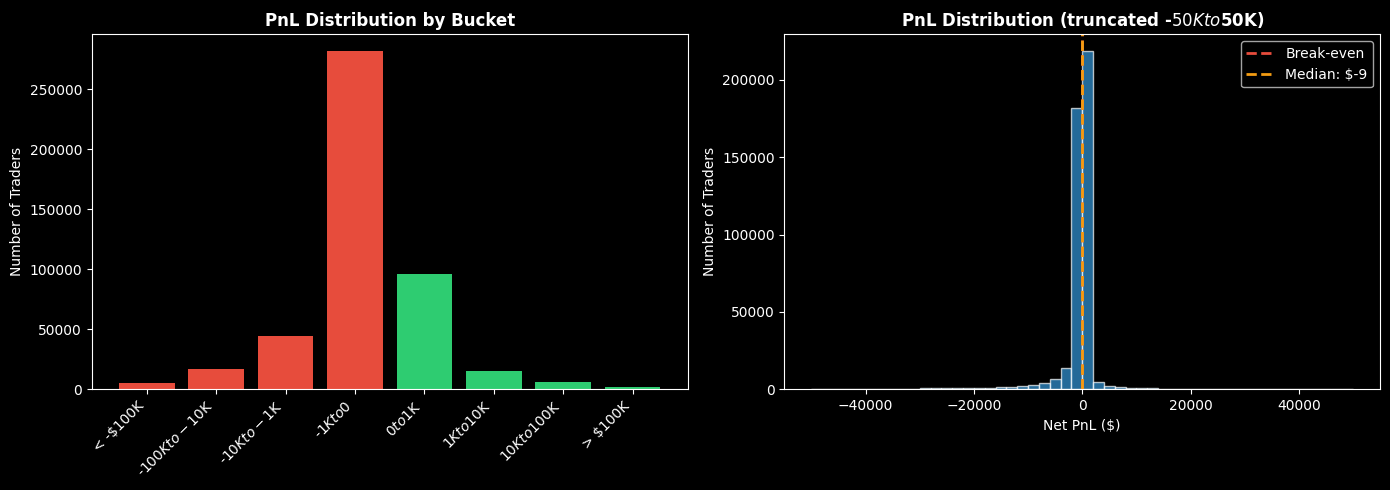

In [52]:
# Visualization: PnL Distribution
if len(pnl_buckets) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of PnL buckets
    buckets = pnl_buckets['pnl_bucket'].to_list()
    traders = pnl_buckets['traders'].to_list()
    
    colors = ['#e74c3c' if '<' in b or '-$' in b else '#2ecc71' for b in buckets]
    axes[0].bar(range(len(buckets)), traders, color=colors)
    axes[0].set_xticks(range(len(buckets)))
    axes[0].set_xticklabels(buckets, rotation=45, ha='right')
    axes[0].set_ylabel('Number of Traders')
    axes[0].set_title('PnL Distribution by Bucket', fontsize=12, fontweight='bold')
    
    # Get full PnL data for histogram
    pnl_data = query("""
        SELECT net_pnl FROM trader_profiles 
        WHERE net_pnl BETWEEN -50000 AND 50000
    """)
    if len(pnl_data) > 0:
        pnl_values = [float(p) for p in pnl_data['net_pnl'].to_list()]
        axes[1].hist(pnl_values, bins=50, color='#3498db', edgecolor='white', alpha=0.7)
        axes[1].axvline(x=0, color='#e74c3c', linestyle='--', linewidth=2, label='Break-even')
        axes[1].axvline(x=np.median(pnl_values), color='#f39c12', linestyle='--', linewidth=2, label=f'Median: ${np.median(pnl_values):,.0f}')
        axes[1].set_xlabel('Net PnL ($)')
        axes[1].set_ylabel('Number of Traders')
        axes[1].set_title('PnL Distribution (truncated -$50K to $50K)', fontsize=12, fontweight='bold')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()

---
## 9. Maker vs Taker Analysis

How does maker % correlate with profitability?

In [53]:
# Performance by maker % bucket
query("""
    SELECT 
        CASE 
            WHEN maker_pct >= 0.9 THEN '90-100%'
            WHEN maker_pct >= 0.7 THEN '70-90%'
            WHEN maker_pct >= 0.5 THEN '50-70%'
            WHEN maker_pct >= 0.3 THEN '30-50%'
            ELSE '0-30%'
        END as maker_bucket,
        COUNT(*) as traders,
        ROUND(SUM(total_volume)::numeric, 0) as total_volume,
        ROUND(SUM(net_pnl)::numeric, 2) as total_pnl,
        ROUND(AVG(net_pnl)::numeric, 2) as avg_pnl,
        SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END) as profitable_count,
        ROUND(SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END)::numeric / COUNT(*) * 100, 1) as profitable_pct
    FROM trader_profiles
    GROUP BY 1
    ORDER BY 1 DESC
""")

maker_bucket,traders,total_volume,total_pnl,avg_pnl,profitable_count,profitable_pct
str,i64,"decimal[38,0]","decimal[38,2]","decimal[38,2]",i64,"decimal[38,1]"
"""90-100%""",14447,465411388428,-669933479.88,-46371.81,5319,36.8
"""70-90%""",13576,356051238897,64960150.35,4784.93,5044,37.2
"""50-70%""",23125,329975634751,-89433464.08,-3867.39,8037,34.8
"""30-50%""",26718,498561202872,-1193769204.64,-44680.34,8007,30.0
"""0-30%""",389323,1104714267136,-1673351501.30,-4298.11,83021,21.3


---
## 10. Coin / Asset Analysis

Volume and activity by trading pair.

In [54]:
# Top coins by volume
query("""
    SELECT 
        coin,
        SUM(fill_count) as fills,
        SUM(unique_traders) as traders,
        ROUND(SUM(volume)::numeric, 2) as volume,
        ROUND(SUM(buy_volume)::numeric, 2) as buy_volume,
        ROUND(SUM(sell_volume)::numeric, 2) as sell_volume,
        ROUND((SUM(buy_volume) / NULLIF(SUM(sell_volume), 0))::numeric, 2) as buy_sell_ratio
    FROM coin_daily
    GROUP BY coin
    ORDER BY SUM(volume) DESC
    LIMIT 20
""")

coin,fills,traders,volume,buy_volume,sell_volume,buy_sell_ratio
str,"decimal[38,0]","decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""BTC""",100318892,1604629,936268487577.24,450136609288.40,450476500377.64,1.00
"""ETH""",79365018,1222412,831851136338.20,399217502046.70,399639957220.10,1.00
"""SOL""",48561848,954958,246014652424.63,116448158664.96,116622828230.31,1.00
"""HYPE""",130257612,1073299,149601400008.62,72160193698.89,72204381645.76,1.00
"""XRP""",13139892,331541,46066891910.36,22099153663.97,22137427011.52,1.00
…,…,…,…,…,…,…
"""LINK""",7192168,198263,12430466294.04,6004952394.86,6018772462.84,1.00
"""BNB""",6137334,202403,11671511309.65,5642182216.54,5640923572.72,1.00
"""SUI""",7206346,207454,11670186438.55,5613971555.11,5618004477.38,1.00


In [55]:
# Liquidation activity by coin
query("""
    SELECT 
        coin,
        SUM(liquidation_count) as liquidations,
        ROUND(SUM(liquidation_volume)::numeric, 2) as liq_volume,
        ROUND(SUM(volume)::numeric, 2) as total_volume,
        ROUND((SUM(liquidation_volume) / NULLIF(SUM(volume), 0) * 100)::numeric, 2) as liq_pct
    FROM coin_daily
    GROUP BY coin
    HAVING SUM(liquidation_count) > 0
    ORDER BY SUM(liquidation_volume) DESC
    LIMIT 20
""")

coin,liquidations,liq_volume,total_volume,liq_pct
str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""BTC""",885362,19557862117.61,936268487577.24,2.09
"""ETH""",559618,15792430087.18,831851136338.20,1.90
"""SOL""",407402,5087486213.11,246014652424.63,2.07
"""HYPE""",941556,2369163829.29,149601400008.62,1.58
"""XPL""",196750,1247184765.25,32447171376.54,3.84
…,…,…,…,…
"""SUI""",49074,204636873.92,11670186438.55,1.75
"""LTC""",20488,170664547.25,6116923124.17,2.79
"""POPCAT""",33782,167293349.85,1523052753.14,10.98


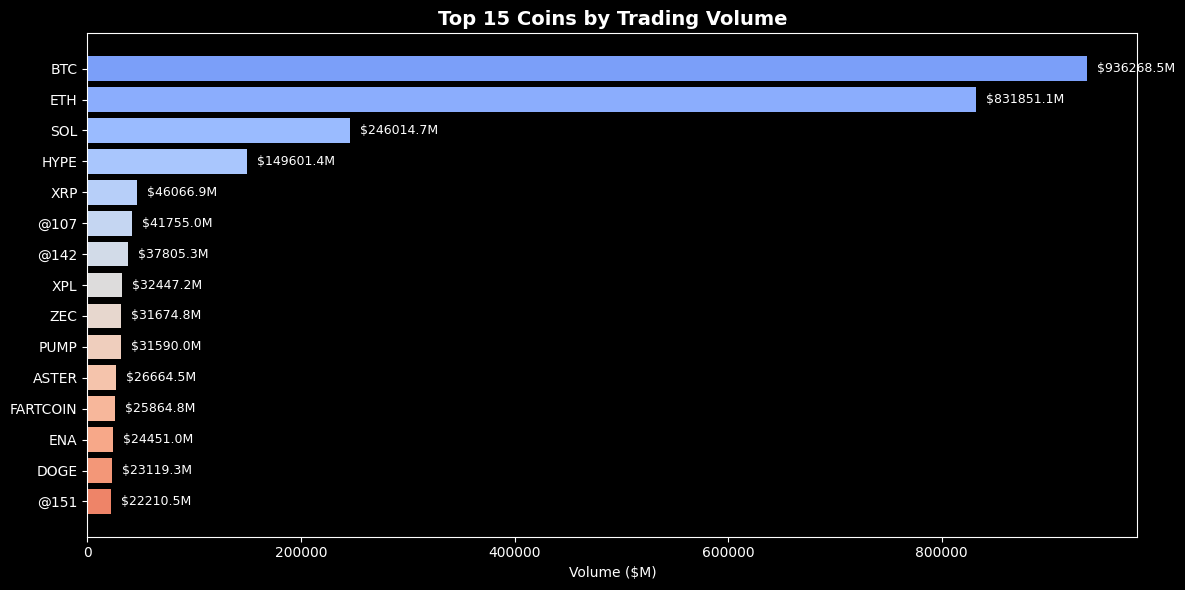

In [56]:
# Visualization: Top Coins by Volume
coin_data = query("""
    SELECT 
        coin,
        SUM(fill_count) as fills,
        ROUND(SUM(volume)::numeric, 2) as volume
    FROM coin_daily
    GROUP BY coin
    ORDER BY SUM(volume) DESC
    LIMIT 15
""")

if len(coin_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    coins = coin_data['coin'].to_list()
    volumes = [float(v)/1e6 for v in coin_data['volume'].to_list()]
    
    colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(coins)))
    bars = ax.barh(coins[::-1], volumes[::-1], color=colors[::-1])
    
    ax.set_xlabel('Volume ($M)')
    ax.set_title('Top 15 Coins by Trading Volume', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar, vol in zip(bars, volumes[::-1]):
        ax.text(bar.get_width() + max(volumes)*0.01, bar.get_y() + bar.get_height()/2,
                f'${vol:.1f}M', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

---
## 11. Smart Money Signals

Aggregate positioning from smart directional traders. This is the core signal:
- When smart traders cluster on one side → potential alpha
- L/S ratio > 2x with multiple traders → high conviction signal

In [57]:
# Smart money recent activity by coin (using smart_money_positions view)
query("""
    SELECT 
        coin,
        SUM(smart_trader_count) as smart_traders,
        SUM(smart_long_volume + smart_short_volume) as total_open_volume,
        ROUND(SUM(smart_long_volume)::numeric, 2) as long_volume,
        ROUND(SUM(smart_short_volume)::numeric, 2) as short_volume,
        ROUND((SUM(smart_long_volume) / NULLIF(SUM(smart_short_volume), 0))::numeric, 2) as ls_ratio
    FROM smart_money_positions
    GROUP BY coin
    HAVING SUM(smart_trader_count) >= 2
    ORDER BY SUM(smart_long_volume + smart_short_volume) DESC
    LIMIT 15
""")

coin,smart_traders,total_open_volume,long_volume,short_volume,ls_ratio
str,"decimal[38,0]","decimal[38,7]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""BTC""",261185,42865529126.2547000,19062926015.67,23802603110.58,0.80
"""ETH""",302902,42612649750.3335900,16996721963.76,25615927786.57,0.66
"""SOL""",112710,9717979581.8672000,3850415091.10,5867564490.77,0.66
"""HYPE""",117820,9012075679.1891700,4364636874.90,4647438804.29,0.94
"""PUMP""",96834,2424673012.7904420,1116917846.37,1307755166.42,0.85
…,…,…,…,…,…
"""FARTCOIN""",116163,1371430751.8670220,513780738.22,857650013.65,0.60
"""DOGE""",77467,1158930813.1289000,437633946.00,721296867.13,0.61
"""LINK""",52308,724869906.3826700,214472169.77,510397736.61,0.42


In [58]:
# Most recent smart trader fills (using smart_money_positions view - hourly aggregates)
# Note: For individual fills, you'd need to query fills with a time filter
query("""
    SELECT 
        hour as ts,
        coin,
        smart_trader_count as traders,
        ROUND(smart_long_volume::numeric, 2) as long_volume,
        ROUND(smart_short_volume::numeric, 2) as short_volume,
        ROUND((smart_long_volume + smart_short_volume)::numeric, 2) as total_volume
    FROM smart_money_positions
    ORDER BY hour DESC
    LIMIT 30
""")

ts,coin,traders,long_volume,short_volume,total_volume
"datetime[μs, Etc/UTC]",str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]"
2025-12-01 12:00:00 UTC,"""@254""",3,0.00,0.00,0.00
2025-12-01 12:00:00 UTC,"""APE""",2,0.00,0.00,0.00
2025-12-01 12:00:00 UTC,"""@210""",4,0.00,0.00,0.00
2025-12-01 12:00:00 UTC,"""@248""",1,0.00,0.00,0.00
2025-12-01 12:00:00 UTC,"""AIXBT""",9,210.37,460.91,671.27
…,…,…,…,…,…
2025-12-01 12:00:00 UTC,"""ADA""",22,175387.06,3733.18,179120.23
2025-12-01 12:00:00 UTC,"""@107""",19,0.00,0.00,0.00
2025-12-01 12:00:00 UTC,"""@206""",1,0.00,0.00,0.00


---
## 12. Win Rate Analysis

How does win rate relate to profitability?

In [59]:
# Win rate buckets
query("""
    SELECT 
        CASE 
            WHEN win_rate >= 0.7 THEN '70%+'
            WHEN win_rate >= 0.6 THEN '60-70%'
            WHEN win_rate >= 0.5 THEN '50-60%'
            WHEN win_rate >= 0.4 THEN '40-50%'
            ELSE '< 40%'
        END as win_rate_bucket,
        COUNT(*) as traders,
        SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END) as profitable,
        ROUND(SUM(CASE WHEN net_pnl > 0 THEN 1 ELSE 0 END)::numeric / COUNT(*) * 100, 1) as profitable_pct,
        ROUND(AVG(net_pnl)::numeric, 2) as avg_pnl,
        ROUND(SUM(net_pnl)::numeric, 2) as total_pnl
    FROM trader_profiles
    WHERE win_rate IS NOT NULL
    GROUP BY 1
    ORDER BY 1 DESC
""")

win_rate_bucket,traders,profitable,profitable_pct,avg_pnl,total_pnl
str,i64,i64,"decimal[38,1]","decimal[38,2]","decimal[38,2]"
"""< 40%""",187543,11106,5.9,-17084.36,-3204051267.37
"""70%+""",92852,60529,65.2,5450.43,506083445.45
"""60-70%""",35512,12017,33.8,2053.48,72923094.74
"""50-60%""",63716,17310,27.2,-4351.92,-277287165.76
"""40-50%""",48980,8466,17.3,-13373.02,-655010562.96


In [60]:
# High win rate traders (>60%) with significant volume
query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(win_rate * 100, 1) as win_rate,
        ROUND(mtm_tv * 10000, 2) as edge_bps
    FROM trader_profiles
    WHERE win_rate >= 0.6 AND total_volume > 100000
    ORDER BY net_pnl DESC
    LIMIT 20
""")

user_address,trader_type,trades,volume,net_pnl,win_rate,edge_bps
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,2]"
"""0xb317d2bc2d3d2df5fa441b5bae0a…","""SMART_DIRECTIONAL""",120701,3556427930.99,101167760.30,97.7,286.63
"""0x5b5d51203a0f9079f8aeb098a652…","""SMART_DIRECTIONAL""",1039142,2213565921.91,66023950.03,62.7,300.37
"""0xb83de012dba672c76a7dbbbf3e45…","""SMART_DIRECTIONAL""",795111,2118978950.04,59551412.43,69.3,283.40
"""0xa312114b5795dff9b8db50474dd5…","""SMART_DIRECTIONAL""",515452,613521593.97,49053631.67,62.5,800.60
"""0x880ac484a1743862989a441d6d86…","""SMART_DIRECTIONAL""",639613,1875415557.54,47913705.54,66.3,256.10
…,…,…,…,…,…,…
"""0x82d8dc80190e6bc1d92b048f9fc7…","""SMART_DIRECTIONAL""",4630,22259982.40,14016196.90,100.0,6301.52
"""0x8af700ba841f30e0a3fcb0ee4c4a…","""SMART_DIRECTIONAL""",54292,649208312.13,13696189.41,60.1,215.72
"""0xd282232463d50d54ccbccf0edc5c…","""SMART_DIRECTIONAL""",44726,69846427.85,13271496.85,100.0,1902.79


---
## 13. Sharpe Ratio Analysis

Risk-adjusted returns. Sharpe = (mean daily PnL) / (std daily PnL) * sqrt(365)

- **< 1.0**: Below average
- **1.0 - 2.0**: Good
- **2.0 - 3.0**: Excellent  
- **> 3.0**: Exceptional (or data issues)

In [61]:
# Sharpe distribution by trader type
query("""
    SELECT 
        trader_type,
        COUNT(*) as traders,
        ROUND(AVG(sharpe_ratio)::numeric, 2) as avg_sharpe,
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sharpe_ratio)::numeric, 2) as median_sharpe,
        ROUND(MAX(sharpe_ratio)::numeric, 2) as max_sharpe
    FROM trader_profiles
    WHERE sharpe_ratio IS NOT NULL AND trading_days >= 5
    GROUP BY trader_type
    ORDER BY avg_sharpe DESC
""")

trader_type,traders,avg_sharpe,median_sharpe,max_sharpe
str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""SMART_DIRECTIONAL""",1573,5.80,4.73,114.84
"""HFT""",5290,-0.98,0.18,35.43
"""RETAIL""",212920,-1.81,-2.23,232.83
"""LIQUIDATOR""",13976,-7.84,-7.88,28.23


In [62]:
# Best risk-adjusted performers (high Sharpe + meaningful activity)
query("""
    SELECT 
        user_address,
        trader_type,
        trading_days as days,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND(sharpe_ratio::numeric, 2) as sharpe,
        ROUND(win_rate * 100, 1) as win_rate
    FROM trader_profiles
    WHERE sharpe_ratio IS NOT NULL 
      AND trading_days >= 10
      AND total_volume > 50000
    ORDER BY sharpe_ratio DESC
    LIMIT 20
""")

user_address,trader_type,days,trades,volume,net_pnl,sharpe,win_rate
str,str,i64,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,1]"
"""0xc227402b700a04862137fb3fcf1c…","""RETAIL""",11,76,308158.95,17.64,45.79,78.6
"""0xd96a6daf24b134bb007d32ce629b…","""RETAIL""",16,14001,4133172.87,23156.04,33.42,93.1
"""0xc1f0e177a6d476814b310f82adac…","""RETAIL""",17,4960,13107620.37,43467.22,32.61,72.7
"""0x1e03431db0f1b0bb824d8b6fd3eb…","""RETAIL""",14,9102,2416696.90,10593.80,31.98,87.5
"""0x083312b529bb5e4c87011b8f3edb…","""RETAIL""",16,12276,3500069.92,20513.86,31.90,96.8
…,…,…,…,…,…,…,…
"""0x22cb727fec12415ee579232760c4…","""RETAIL""",12,34,54520.42,37331.82,26.60,100.0
"""0x3161dcb17c7beaf05f23cdd6b865…","""RETAIL""",22,294,171830.24,476.34,26.53,96.7
"""0x16c95227d8442946c1c152bc8ea1…","""HFT""",128,598946,391853281.15,275984.83,26.45,99.0


---
## 14. Builder / Frontend Analysis

Which frontends/builders are traders using?

In [63]:
# Top builders by volume (using builder_daily continuous aggregate)
query("""
    SELECT 
        builder,
        SUM(fill_count)::bigint as fills,
        SUM(unique_traders)::bigint as traders,
        ROUND(SUM(volume)::numeric, 2) as volume,
        ROUND(SUM(builder_fees)::numeric, 2) as builder_fees
    FROM builder_daily
    GROUP BY builder
    ORDER BY SUM(volume) DESC
    LIMIT 15
""")

builder,fills,traders,volume,builder_fees
str,i64,i64,"decimal[38,2]","decimal[38,2]"
"""direct""",877348731,4491608,2644631496608.19,0.00
"""0x1924b8561eef20e70ede628a2961…",41562258,477107,34563500213.48,11721864.37
"""0xb84168cf3be63c6b8dad05ff5d75…",7021805,578642,20624113087.33,10312053.45
"""0x2868fc0d9786a740b491577a4350…",4404288,29858,18899414617.44,1859184.02
"""0x1cc34f6af34653c515b47a83e1de…",2653899,132546,8350720316.52,835070.79
…,…,…,…,…
"""0xcf56dd84ed85eb4929e0a76a0f2f…",405009,37926,1526822211.19,782167.14
"""0x6530512a6c89c7cfcebc3ba7fcd9…",4167376,7041,1407877764.46,115414.44
"""0x0000000bfbf4c62c43c2e71ef009…",418318,11368,1299575662.20,212453.86


---
## 15. Time-Based Activity Patterns

In [64]:
# Daily volume trend
daily_volume = query("""
    SELECT 
        day,
        to_timestamp(day/1000)::date as date,
        SUM(fill_count) as fills,
        COUNT(DISTINCT user_address) as traders,
        ROUND(SUM(volume)::numeric, 2) as volume,
        ROUND(SUM(realized_pnl)::numeric, 2) as pnl
    FROM trader_daily
    GROUP BY day
    ORDER BY day
""")
daily_volume

day,date,fills,traders,volume,pnl
i64,date,"decimal[38,0]",i64,"decimal[38,2]","decimal[38,2]"
1753574400000,2025-07-27,4462170,29975,11731883014.88,6822686.92
1753660800000,2025-07-28,9366075,44790,25773237819.48,5759614.29
1753747200000,2025-07-29,9172210,42482,23783193872.94,-6329079.70
1753833600000,2025-07-30,7845947,43021,21168013986.50,-15768501.21
1753920000000,2025-07-31,8863553,42061,23826264655.56,7290009.59
…,…,…,…,…,…
1764201600000,2025-11-27,5675748,48889,10014544456.43,15395226.92
1764288000000,2025-11-28,6151830,46469,11553471178.12,3750660.86
1764374400000,2025-11-29,4100892,32712,6140524123.31,4461827.49


In [65]:
# Daily stats summary using Polars
if len(daily_volume) > 0:
    daily_volume.select([
        pl.col("fills").cast(pl.Float64).mean().round(0).alias("avg_daily_fills"),
        pl.col("traders").cast(pl.Float64).mean().round(0).alias("avg_daily_traders"),
        pl.col("volume").cast(pl.Float64).mean().round(0).alias("avg_daily_volume"),
        pl.col("volume").cast(pl.Float64).max().alias("max_daily_volume"),
        pl.col("pnl").cast(pl.Float64).sum().round(2).alias("total_pnl"),
    ])
else:
    print("No daily data found")

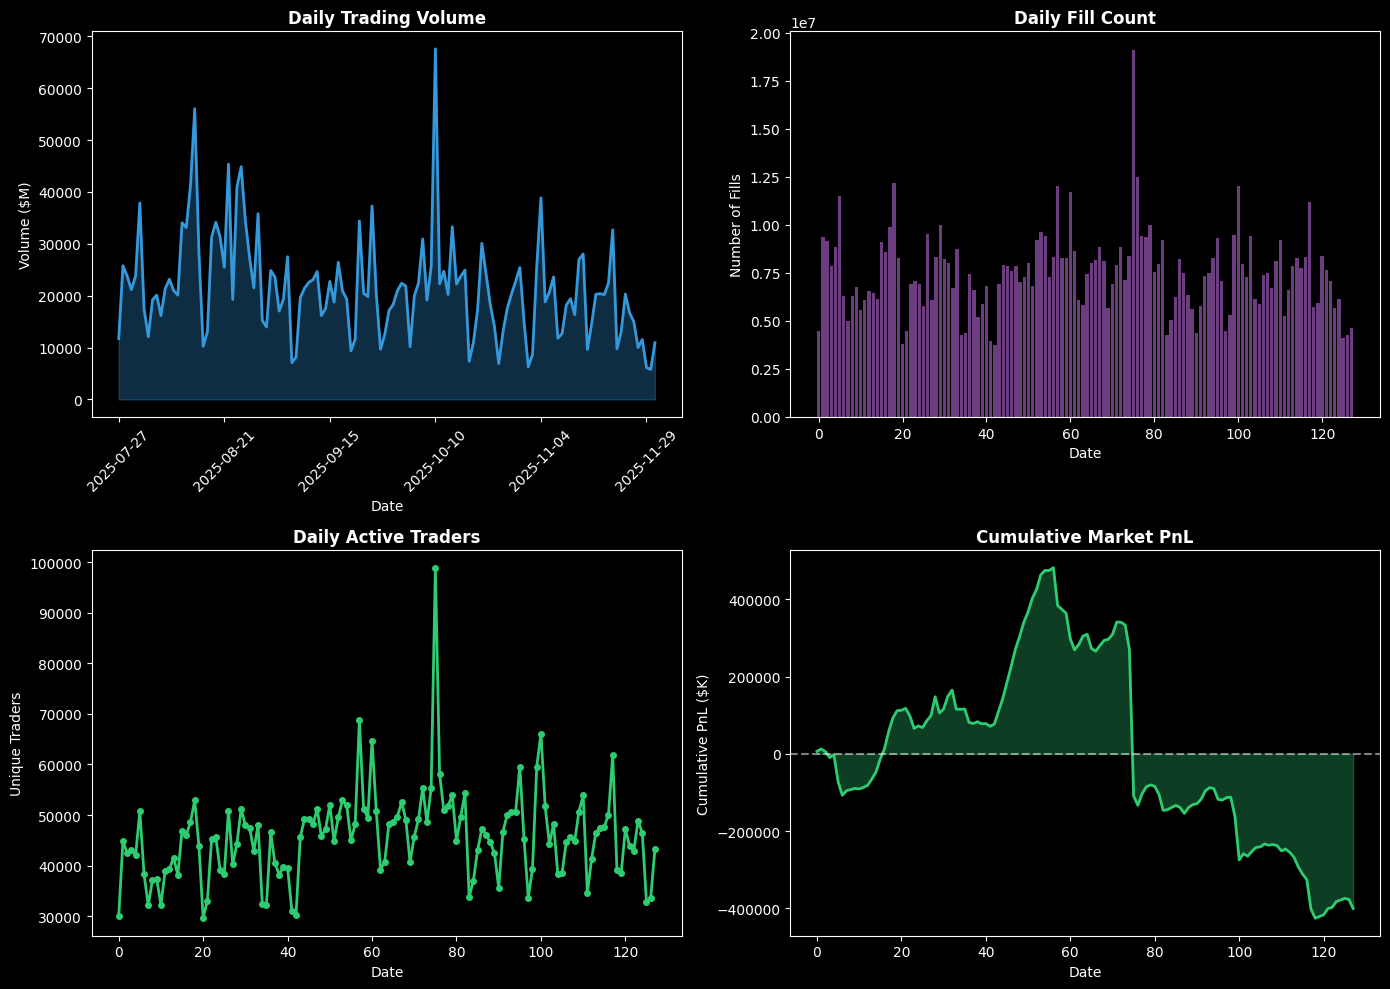

In [66]:
# Visualization: Daily Volume and Activity Trends
if len(daily_volume) > 0 and len(daily_volume) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    dates = daily_volume['date'].to_list()
    volumes = [float(v)/1e6 for v in daily_volume['volume'].to_list()]
    fills = [int(f) for f in daily_volume['fills'].to_list()]
    traders = [int(t) for t in daily_volume['traders'].to_list()]
    pnls = [float(p)/1000 for p in daily_volume['pnl'].to_list()]
    
    # Volume over time
    axes[0, 0].fill_between(range(len(dates)), volumes, alpha=0.3, color='#3498db')
    axes[0, 0].plot(range(len(dates)), volumes, color='#3498db', linewidth=2)
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Volume ($M)')
    axes[0, 0].set_title('Daily Trading Volume', fontsize=12, fontweight='bold')
    if len(dates) > 5:
        axes[0, 0].set_xticks(range(0, len(dates), max(1, len(dates)//5)))
        axes[0, 0].set_xticklabels([str(dates[i]) for i in range(0, len(dates), max(1, len(dates)//5))], rotation=45)
    
    # Fills over time
    axes[0, 1].bar(range(len(dates)), fills, color='#9b59b6', alpha=0.7)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Number of Fills')
    axes[0, 1].set_title('Daily Fill Count', fontsize=12, fontweight='bold')
    
    # Active traders over time
    axes[1, 0].plot(range(len(dates)), traders, color='#2ecc71', linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Unique Traders')
    axes[1, 0].set_title('Daily Active Traders', fontsize=12, fontweight='bold')
    
    # Cumulative PnL
    cum_pnl = np.cumsum(pnls)
    colors = ['#2ecc71' if p >= 0 else '#e74c3c' for p in cum_pnl]
    axes[1, 1].fill_between(range(len(dates)), cum_pnl, alpha=0.3, color='#2ecc71')
    axes[1, 1].plot(range(len(dates)), cum_pnl, color='#2ecc71', linewidth=2)
    axes[1, 1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Cumulative PnL ($K)')
    axes[1, 1].set_title('Cumulative Market PnL', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough daily data for time series visualization")

---
## 16. Summary Statistics

In [67]:
# Pull key metrics for summary
profiles = query("""
    SELECT 
        trader_type,
        total_fills,
        total_volume,
        net_pnl,
        maker_pct,
        win_rate,
        mtm_tv,
        sharpe_ratio
    FROM trader_profiles
    WHERE total_volume > 1000
""")

if len(profiles) > 0:
    # Cast to float for calculations
    total_volume = profiles['total_volume'].cast(pl.Float64).sum()
    net_pnl = profiles['net_pnl'].cast(pl.Float64).sum()
    profitable = (profiles['net_pnl'].cast(pl.Float64) > 0).sum()
    pct_profitable = profitable / len(profiles) * 100
    
    print(f"Total traders analyzed: {len(profiles):,}")
    print(f"Total volume: ${total_volume:,.0f}")
    print(f"Net PnL (all traders): ${net_pnl:,.2f}")
    print(f"Profitable traders: {profitable:,} ({pct_profitable:.1f}%)")
else:
    print("No trader profiles found")

Total traders analyzed: 343,537
Total volume: $2,754,678,041,215
Net PnL (all traders): $-3,558,290,226.94
Profitable traders: 83,256 (24.2%)


In [68]:
# Trader type breakdown
if len(profiles) > 0:
    profiles.with_columns([
        pl.col("total_volume").cast(pl.Float64),
        pl.col("net_pnl").cast(pl.Float64),
    ]).group_by("trader_type").agg([
        pl.len().alias("count"),
        pl.col("total_volume").sum().round(0).alias("volume"),
        pl.col("net_pnl").sum().round(2).alias("pnl"),
        (pl.col("net_pnl") > 0).mean().mul(100).round(1).alias("profitable_pct"),
    ]).sort("pnl", descending=True)
else:
    print("No data")

---
## 17. Fresh Wallet Detection

From VISION.md: "Fresh wallet activity" - wallets < 7 days old with volume > 2x average.
These could be new alpha sources or wash trading.

In [69]:
# Fresh wallets (first trade within last 7 days) with significant volume
# Using trader_profiles which has first_trade_time and last_trade_time
fresh_wallets = query("""
    WITH avg_volume AS (
        SELECT AVG(total_volume)::numeric as avg_vol FROM trader_profiles
    )
    SELECT 
        t.user_address,
        t.trader_type,
        ROUND(((t.last_trade_time - t.first_trade_time) / 86400000.0)::numeric, 1) as days_active,
        t.total_fills::bigint as trades,
        ROUND(t.total_volume::numeric, 2) as volume,
        ROUND(t.net_pnl::numeric, 2) as net_pnl,
        ROUND((t.total_volume / a.avg_vol)::numeric, 1) as volume_vs_avg
    FROM trader_profiles t
    CROSS JOIN avg_volume a
    WHERE ((t.last_trade_time - t.first_trade_time) / 86400000.0) <= 7
      AND t.total_volume > a.avg_vol * 2
    ORDER BY t.total_volume DESC
    LIMIT 20
""")
fresh_wallets

user_address,trader_type,days_active,trades,volume,net_pnl,volume_vs_avg
str,str,"decimal[38,1]",i64,"decimal[38,2]","decimal[38,2]","decimal[38,1]"
"""0xfd0e0d2846eb717eaa439d49a4c0…","""RETAIL""",3.0,148195,2202049322.04,-667949.54,373.5
"""0x7c4399a2e5752a57703391da290c…","""RETAIL""",4.0,116248,2163291965.96,-3390948.56,366.9
"""0x149e2691ac0f84804ec31bcffdae…","""RETAIL""",3.0,267738,2063274909.05,-1466744.01,349.9
"""0x100f77599ef354afdec59e26f512…","""RETAIL""",1.0,153139,1370758065.84,-1392760.88,232.5
"""0x2c26b98bba32196e05123db5e146…","""RETAIL""",6.0,53992,1078263825.02,-2037921.76,182.9
…,…,…,…,…,…,…
"""0x93c841b243178bb0584d9d688b7f…","""RETAIL""",6.0,10256,423195750.51,-5667158.75,71.8
"""0x9018960618eff55f5852e345b7cb…","""RETAIL""",5.0,10401,368952052.35,-3626193.48,62.6
"""0x579f4017263b88945d727a927bf1…","""RETAIL""",5.0,45987,367346994.17,124400.06,62.3


---
## 18. Whale Position Detection

Smart traders opening large positions (>$500K notional) - potential market-moving activity.

In [70]:
# Large positions from smart traders (potential whale signals)
# Using smart_money_positions view aggregated by hour
query("""
    SELECT 
        hour as ts,
        coin,
        smart_trader_count as traders,
        ROUND(smart_long_volume::numeric, 2) as long_volume,
        ROUND(smart_short_volume::numeric, 2) as short_volume,
        ROUND((smart_long_volume + smart_short_volume)::numeric, 2) as total_notional,
        CASE 
            WHEN smart_long_volume > smart_short_volume THEN 'NET LONG'
            WHEN smart_short_volume > smart_long_volume THEN 'NET SHORT'
            ELSE 'NEUTRAL'
        END as direction
    FROM smart_money_positions
    WHERE (smart_long_volume + smart_short_volume) >= 500000
    ORDER BY hour DESC
    LIMIT 30
""")

ts,coin,traders,long_volume,short_volume,total_notional,direction
"datetime[μs, Etc/UTC]",str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]",str
2025-12-01 12:00:00 UTC,"""ZEC""",99,1192862.58,476688.71,1669551.29,"""NET LONG"""
2025-12-01 12:00:00 UTC,"""ETH""",138,46749107.31,18474020.59,65223127.90,"""NET LONG"""
2025-12-01 12:00:00 UTC,"""SOL""",25,119453.92,784575.48,904029.40,"""NET SHORT"""
2025-12-01 12:00:00 UTC,"""xyz:NVDA""",4,7999.90,498980.32,506980.21,"""NET SHORT"""
2025-12-01 12:00:00 UTC,"""xyz:XYZ100""",1,1061735.56,0.00,1061735.56,"""NET LONG"""
…,…,…,…,…,…,…
2025-12-01 06:00:00 UTC,"""HYPE""",26,31319.43,607921.88,639241.31,"""NET SHORT"""
2025-12-01 06:00:00 UTC,"""BTC""",120,1195480.45,3863136.16,5058616.61,"""NET SHORT"""
2025-12-01 06:00:00 UTC,"""ZEC""",91,466933.89,386472.90,853406.79,"""NET LONG"""


---
## 19. Smart Money Z-Score Signals

Statistical measure of smart money clustering. Z-score > 1.5 with L/S ratio > 2x = high conviction signal.

In [71]:
# Smart money activity z-scores by coin
# Uses smart_money_positions view
smart_zscore = query("""
    WITH smart_activity AS (
        SELECT 
            coin,
            SUM(smart_trader_count) as smart_traders,
            SUM(smart_long_volume) as long_vol,
            SUM(smart_short_volume) as short_vol
        FROM smart_money_positions
        GROUP BY coin
    ),
    coin_stats AS (
        SELECT 
            AVG(smart_traders)::numeric as avg_traders,
            COALESCE(NULLIF(STDDEV(smart_traders), 0), 1)::numeric as std_traders
        FROM smart_activity
    )
    SELECT 
        a.coin,
        a.smart_traders::bigint,
        ROUND(a.long_vol::numeric, 2) as long_volume,
        ROUND(a.short_vol::numeric, 2) as short_volume,
        ROUND((a.long_vol / NULLIF(a.short_vol, 0))::numeric, 2) as ls_ratio,
        ROUND(((a.smart_traders::numeric - s.avg_traders) / s.std_traders), 2) as trader_zscore
    FROM smart_activity a
    CROSS JOIN coin_stats s
    WHERE a.smart_traders >= 3
    ORDER BY a.long_vol + a.short_vol DESC
    LIMIT 15
""")
smart_zscore

coin,smart_traders,long_volume,short_volume,ls_ratio,trader_zscore
str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""BTC""",261185,19062926015.67,23802603110.58,0.80,8.42
"""ETH""",302902,16996721963.76,25615927786.57,0.66,9.83
"""SOL""",112710,3850415091.10,5867564490.77,0.66,3.38
"""HYPE""",117820,4364636874.90,4647438804.29,0.94,3.55
"""PUMP""",96834,1116917846.37,1307755166.42,0.85,2.84
…,…,…,…,…,…
"""FARTCOIN""",116163,513780738.22,857650013.65,0.60,3.50
"""DOGE""",77467,437633946.00,721296867.13,0.61,2.18
"""LINK""",52308,214472169.77,510397736.61,0.42,1.33


In [72]:
# Filter for high-conviction signals (z-score > 1 AND extreme L/S ratio)
if len(smart_zscore) > 0:
    # Cast decimal to float for comparisons
    signals = smart_zscore.with_columns([
        pl.col("ls_ratio").cast(pl.Float64),
        pl.col("smart_traders").cast(pl.Float64),
    ]).filter(
        (pl.col("ls_ratio").is_not_null()) & 
        ((pl.col("ls_ratio") >= 2.0) | (pl.col("ls_ratio") <= 0.5)) &
        (pl.col("smart_traders") >= 3)
    ).with_columns(
        pl.when(pl.col("ls_ratio") >= 2.0)
          .then(pl.lit("BULLISH"))
          .otherwise(pl.lit("BEARISH"))
          .alias("signal")
    )
    print(f"High conviction signals: {len(signals)}")
    if len(signals) > 0:
        signals
    else:
        print("No high conviction signals found")
else:
    print("No smart money activity data")

High conviction signals: 4


---
## 20. Profit Factor Analysis

**Profit Factor = Gross Wins / Gross Losses**
- \> 1.5: Solid trading system
- \> 2.0: Very good
- \> 3.0: Excellent

In [73]:
# Profit factor by trader (using trader_daily continuous aggregate)
# Note: trader_daily has winning_fills and losing_fills counts, but not gross_wins/losses
# We use win_rate and net_pnl as proxies from trader_profiles
query("""
    SELECT 
        t.user_address,
        t.trader_type,
        t.total_fills::bigint as trades,
        ROUND(t.net_pnl::numeric, 2) as net_pnl,
        ROUND(t.win_rate * 100, 1) as win_rate_pct,
        ROUND(t.sharpe_ratio::numeric, 2) as sharpe_ratio,
        t.trading_days
    FROM trader_profiles t
    WHERE t.net_pnl > 0 AND t.trading_days >= 5
    ORDER BY t.sharpe_ratio DESC NULLS LAST
    LIMIT 20
""")

user_address,trader_type,trades,net_pnl,win_rate_pct,sharpe_ratio,trading_days
str,str,i64,"decimal[38,2]","decimal[38,1]","decimal[38,2]",i64
"""0x677b8d3d49c92168a38c3de90d59…","""RETAIL""",8,5951.71,100.0,232.83,5
"""0xc877d99c6258c55d51492b721e54…","""SMART_DIRECTIONAL""",140,196421.10,100.0,114.84,7
"""0x6d2124d9637f76d0de2e128d5924…","""RETAIL""",362,10.63,100.0,86.20,9
"""0x57510472ed8c3f52901d034293ca…","""RETAIL""",167,493.82,93.9,66.93,6
"""0x483009eb3aef5e7076aa36667eeb…","""RETAIL""",5,1105.99,100.0,65.45,5
…,…,…,…,…,…,…
"""0xc227402b700a04862137fb3fcf1c…","""RETAIL""",76,17.64,78.6,45.79,11
"""0xe9edb00e71c623de51b92fd85490…","""RETAIL""",14,14465.68,100.0,45.02,5
"""0x1fc2caf9d9c6437345a089715dc8…","""RETAIL""",21,3101.92,100.0,44.12,8


---
## 21. Fee Efficiency Analysis

Are traders losing more to fees than they make in profit?

In [74]:
# Fee efficiency by trader type
query("""
    SELECT 
        trader_type,
        COUNT(*) as traders,
        ROUND(SUM(fees_paid)::numeric, 2) as total_fees,
        ROUND(SUM(net_pnl)::numeric, 2) as total_pnl,
        ROUND((SUM(fees_paid) / NULLIF(ABS(SUM(net_pnl)), 0) * 100)::numeric, 1) as fees_pct_of_pnl,
        ROUND(AVG(fees_paid / NULLIF(total_volume, 0) * 10000)::numeric, 2) as avg_fee_bps
    FROM trader_profiles
    GROUP BY trader_type
    ORDER BY total_fees DESC
""")

trader_type,traders,total_fees,total_pnl,fees_pct_of_pnl,avg_fee_bps
str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,1]","decimal[38,2]"
"""RETAIL""",412539,2981811980.47,-5639709695.37,52.9,402.92
"""SMART_DIRECTIONAL""",1773,114265266.04,2301146299.10,5.0,6.16
"""HFT""",11570,27390969.89,-65713216.88,41.7,262.77
"""LIQUIDATOR""",41307,3566167.98,-157250886.40,2.3,9.94


In [75]:
# Traders who lost more in fees than PnL (fee-destroyed)
query("""
    SELECT 
        user_address,
        trader_type,
        total_fills as trades,
        ROUND(total_volume::numeric, 2) as volume,
        ROUND(fees_paid::numeric, 2) as fees,
        ROUND(net_pnl::numeric, 2) as net_pnl,
        ROUND((fees_paid / NULLIF(ABS(net_pnl), 0) * 100)::numeric, 1) as fees_pct_of_pnl
    FROM trader_profiles
    WHERE fees_paid > ABS(net_pnl) 
      AND total_volume > 10000
    ORDER BY fees_paid DESC
    LIMIT 20
""")

user_address,trader_type,trades,volume,fees,net_pnl,fees_pct_of_pnl
str,str,"decimal[38,0]","decimal[38,2]","decimal[38,2]","decimal[38,2]","decimal[38,1]"
"""0xe5350e927b904fdb4d2af55c566e…","""RETAIL""",970,2176977.84,397809112.69,-397801738.99,100.0
"""0x1f876d9252596fcaf8d651a6f443…","""RETAIL""",29,71989.47,132909715.75,-132904405.93,100.0
"""0xabdc1406b2cc155f985f4ad1f8fb…","""RETAIL""",414,193721.42,117708520.01,-117701258.16,100.0
"""0x3e154e4e7975dc3646c6e00797d9…","""RETAIL""",41,53940.77,100444152.95,-100443638.21,100.0
"""0xecb63caa47c7c4e77f60f1ce858c…","""SMART_DIRECTIONAL""",23947881,61464324830.84,60141841.28,30702482.59,195.9
…,…,…,…,…,…,…
"""0x53babe76166eae33c861aeddf9ce…","""RETAIL""",934463,21853581002.07,4189859.41,-3485554.14,120.2
"""0x05f11b22d790fe64f7984fa4e592…","""RETAIL""",3496,6999961.37,3992227.36,-3987095.23,100.1
"""0xc01164f649ea2e9e31d0db2331c2…","""RETAIL""",924,5299664.08,3988559.96,-3977475.98,100.3


---
## 22. TWAP Order Analysis

Time-Weighted Average Price orders indicate algorithmic/institutional trading.

In [76]:
# TWAP usage by trader type
query("""
    SELECT 
        trader_type,
        COUNT(*) as traders,
        SUM(twap_fills) as twap_fills,
        SUM(total_fills) as total_fills,
        ROUND(SUM(twap_fills)::numeric / NULLIF(SUM(total_fills), 0) * 100, 2) as twap_pct,
        ROUND(SUM(twap_volume)::numeric, 2) as twap_volume
    FROM trader_profiles
    WHERE twap_fills > 0
    GROUP BY trader_type
    ORDER BY twap_volume DESC
""")

trader_type,traders,twap_fills,total_fills,twap_pct,twap_volume
str,i64,"decimal[38,0]","decimal[38,0]","decimal[38,2]","decimal[38,2]"
"""RETAIL""",15446,54120776,127910231,42.31,51107027653.98
"""SMART_DIRECTIONAL""",558,7926945,28472428,27.84,8336348445.65
"""LIQUIDATOR""",45,29742,90790,32.76,124510919.27
"""HFT""",147,160240,24785724,0.65,43194013.70


In [77]:
# Top TWAP users
query("""
    SELECT 
        user_address,
        trader_type,
        twap_fills,
        total_fills,
        ROUND(twap_fills::numeric / total_fills * 100, 1) as twap_pct,
        ROUND(twap_volume::numeric, 2) as twap_volume,
        ROUND(net_pnl::numeric, 2) as net_pnl
    FROM trader_profiles
    WHERE twap_fills > 0
    ORDER BY twap_volume DESC
    LIMIT 15
""")

user_address,trader_type,twap_fills,total_fills,twap_pct,twap_volume,net_pnl
str,str,"decimal[38,0]","decimal[38,0]","decimal[38,1]","decimal[38,2]","decimal[38,2]"
"""0x4a207d289fd49e60502451099771…","""RETAIL""",326286,631351,51.7,6084013742.74,-19815756.74
"""0x00c511ab1b583f4efab3608d0897…","""RETAIL""",454641,525293,86.5,4694683780.81,-14081476.36
"""0x88b6addc407b2b809443aea0cf54…","""RETAIL""",236946,390478,60.7,1924521360.18,-9661955.91
"""0x1f250df59a777d61cb8bd043c129…","""RETAIL""",71096,122523,58.0,1263642262.06,995901.66
"""0xb28cf8649d1cda2975d290f04ea4…","""RETAIL""",499920,1103775,45.3,1128923236.71,-9021155.44
…,…,…,…,…,…,…
"""0xc50aa1e77492ab1090de92866ae9…","""RETAIL""",88878,138477,64.2,818816393.53,-14107792.77
"""0x469e9a7f624b04c24f0e64edf8d8…","""SMART_DIRECTIONAL""",192414,397542,48.4,780850824.42,5625841.41
"""0x98054753cc4b5ad006f124801f62…","""RETAIL""",483565,626081,77.2,753539485.66,-3837931.59


---
## 23. Trader Consistency Analysis

Are profitable traders consistently profitable, or just lucky?

In [78]:
# Daily consistency for top traders
# What % of their trading days were profitable?
query("""
    WITH daily_pnl AS (
        SELECT 
            user_address,
            day,
            SUM(realized_pnl) as daily_pnl
        FROM trader_daily
        GROUP BY user_address, day
    ),
    consistency AS (
        SELECT 
            user_address,
            COUNT(*) as trading_days,
            SUM(CASE WHEN daily_pnl > 0 THEN 1 ELSE 0 END) as profitable_days,
            ROUND(SUM(CASE WHEN daily_pnl > 0 THEN 1 ELSE 0 END)::numeric / COUNT(*) * 100, 1) as profitable_day_pct
        FROM daily_pnl
        GROUP BY user_address
    )
    SELECT 
        t.user_address,
        t.trader_type,
        c.trading_days,
        c.profitable_days,
        c.profitable_day_pct,
        ROUND(t.net_pnl::numeric, 2) as net_pnl,
        ROUND(t.sharpe_ratio::numeric, 2) as sharpe
    FROM trader_profiles t
    JOIN consistency c ON t.user_address = c.user_address
    WHERE c.trading_days >= 10
      AND t.net_pnl > 10000
    ORDER BY c.profitable_day_pct DESC, t.net_pnl DESC
    LIMIT 20
""")

user_address,trader_type,trading_days,profitable_days,profitable_day_pct,net_pnl,sharpe
str,str,i64,i64,"decimal[38,1]","decimal[38,2]","decimal[38,2]"
"""0x16c95227d8442946c1c152bc8ea1…","""HFT""",128,128,100.0,275984.83,26.45
"""0x5aee200740dea21e6d9ab1f60eda…","""RETAIL""",12,12,100.0,98043.61,29.50
"""0x1c159c89044bafb76fb98e30ef29…","""RETAIL""",17,17,100.0,72898.57,19.13
"""0x9dac116b0f57fdb4c68ab1b485e8…","""RETAIL""",16,16,100.0,70465.00,27.87
"""0x943980b467fe194beb923daf7a54…","""RETAIL""",18,18,100.0,63890.03,20.85
…,…,…,…,…,…,…
"""0xa13c7a21e14c0f2243eb13947b6a…","""RETAIL""",10,10,100.0,10935.28,15.01
"""0x2cfa080c92f7bb3512d407b9ec70…","""RETAIL""",40,40,100.0,10775.75,10.75
"""0x1e03431db0f1b0bb824d8b6fd3eb…","""RETAIL""",14,14,100.0,10593.80,31.98


---
## 24. Position Size Analysis

Average position sizes by trader type - helps understand risk appetite.

In [79]:
# Position size distribution by trader type (using trader_profiles)
# We compute avg position size as volume / fills
query("""
    SELECT 
        trader_type,
        COUNT(*) as traders,
        ROUND(AVG(total_volume / NULLIF(total_fills, 0))::numeric, 2) as avg_position_size,
        ROUND((PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_volume / NULLIF(total_fills, 0)))::numeric, 2) as median_position_size,
        ROUND(MAX(total_volume / NULLIF(total_fills, 0))::numeric, 2) as max_avg_position_size
    FROM trader_profiles
    WHERE total_fills > 0
    GROUP BY trader_type
    ORDER BY avg_position_size DESC
""")

trader_type,traders,avg_position_size,median_position_size,max_avg_position_size
str,i64,"decimal[38,2]","decimal[38,2]","decimal[38,2]"
"""SMART_DIRECTIONAL""",1773,5742.66,2941.25,87946.07
"""HFT""",11570,1392.49,261.70,99900.00
"""RETAIL""",412539,1240.87,367.91,303170.68
"""LIQUIDATOR""",41307,1159.82,214.71,2128393.87


---
## 26. Trader Clustering Analysis (ML)

Use K-Means clustering to discover natural trader segments beyond heuristic classification.
Features used:
- Edge (MTM/TV)
- Maker %
- Win Rate
- Log Volume
- Net PnL (normalized)

In [80]:
# Prepare data for clustering
cluster_data = query("""
    SELECT 
        user_address,
        trader_type,
        total_fills,
        total_volume,
        net_pnl,
        maker_pct,
        win_rate,
        mtm_tv,
        COALESCE(sharpe_ratio, 0) as sharpe_ratio
    FROM trader_profiles
    WHERE total_volume > 10000
      AND total_fills >= 10
      AND win_rate IS NOT NULL
""")

print(f"Traders for clustering: {len(cluster_data)}")
cluster_data.head()

Traders for clustering: 216427


user_address,trader_type,total_fills,total_volume,net_pnl,maker_pct,win_rate,mtm_tv,sharpe_ratio
str,str,"decimal[38,0]","decimal[38,14]","decimal[38,10]","decimal[38,20]","decimal[38,20]","decimal[38,24]",f64
"""0xff02f84074665fa3b6554bf27d9e…","""RETAIL""",722,1088243.84614000000000,-1126.6937690000,0.05263157894736842105,0.47941176470588235294,-0.000598498976410669400000,-2.779228
"""0xff038f0832d6d2ae1e325b5424df…","""RETAIL""",1141,5445052.61195900000000,-3529.1066600000,0.00000000000000000000,0.41571194762684124386,-0.000198130966747787110000,-0.698751
"""0xff041708218fce3fbf18d22ad838…","""RETAIL""",68,97271.19401000000000,5809.2149940000,0.01470588235294117647,1.00000000000000000000,0.060165246654609251880000,11.030261
"""0xff043c6608419ad173134a009d02…","""RETAIL""",61,22995.65069000000000,-38.7772080000,0.11475409836065573770,0.67857142857142857143,-0.001288608893893404330000,-2.78452
"""0xff053d9ac1beb1be7340591b737e…","""RETAIL""",1743,15278790.66268303505530,-15750.5617851470,0.04130808950086058520,0.37009544008483563097,-0.000101296893820274180000,-3.41736


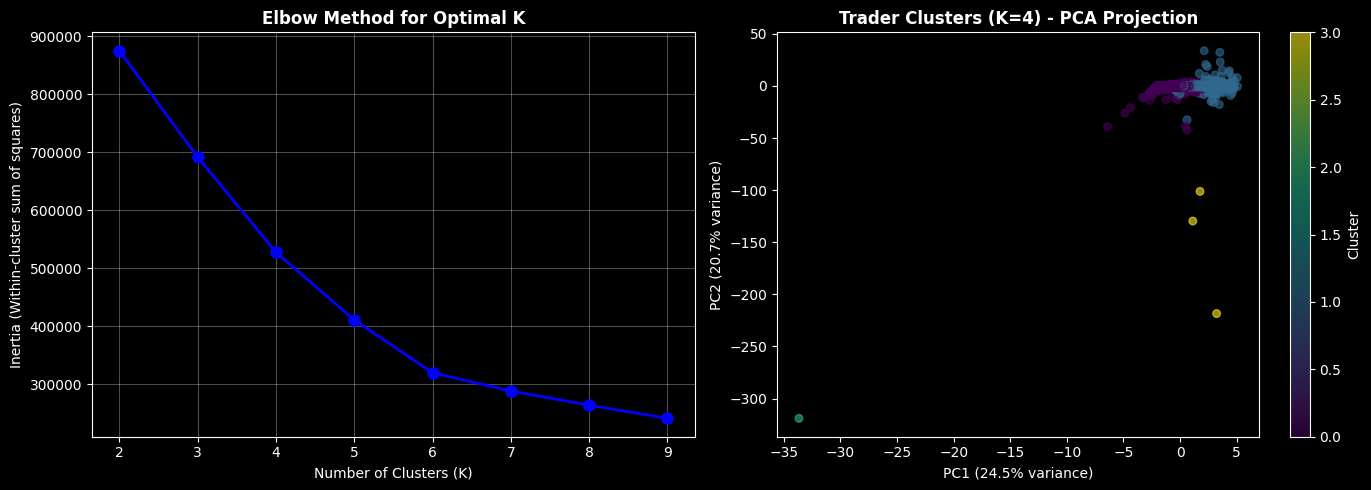


Cluster distribution:
  Cluster 0: 172729 traders (79.8%)
  Cluster 1: 43694 traders (20.2%)
  Cluster 2: 1 traders (0.0%)
  Cluster 3: 3 traders (0.0%)


In [81]:
# Perform K-Means Clustering
if len(cluster_data) >= 20:
    # Prepare features
    features = cluster_data.select([
        pl.col('total_volume').cast(pl.Float64).log().alias('log_volume'),
        pl.col('maker_pct').cast(pl.Float64).alias('maker_pct'),
        pl.col('win_rate').cast(pl.Float64).alias('win_rate'),
        (pl.col('mtm_tv').cast(pl.Float64) * 10000).alias('edge_bps'),
        pl.col('net_pnl').cast(pl.Float64).alias('net_pnl'),
    ]).to_numpy()
    
    # Handle any NaN/inf values
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Find optimal K using elbow method
    inertias = []
    K_range = range(2, min(10, len(cluster_data)//10 + 2))
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (K)')
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
    axes[0].set_title('Elbow Method for Optimal K', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Choose K=4 or 5 based on elbow
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features_scaled)
    
    # Add cluster labels to data
    cluster_data_with_labels = cluster_data.with_columns(
        pl.Series('cluster', clusters)
    )
    
    # PCA for 2D visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_scaled)
    
    # Plot clusters
    scatter = axes[1].scatter(features_2d[:, 0], features_2d[:, 1], 
                               c=clusters, cmap='viridis', alpha=0.6, s=30)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[1].set_title(f'Trader Clusters (K={optimal_k}) - PCA Projection', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=axes[1], label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCluster distribution:")
    for i in range(optimal_k):
        count = (clusters == i).sum()
        print(f"  Cluster {i}: {count} traders ({count/len(clusters)*100:.1f}%)")
else:
    print("Not enough data for clustering (need at least 20 traders)")

In [82]:
# Cluster Profiling - Understand what each cluster represents
if len(cluster_data) >= 20 and 'cluster_data_with_labels' in dir():
    print("=" * 70)
    print("CLUSTER PROFILES")
    print("=" * 70)
    
    cluster_profiles = cluster_data_with_labels.group_by('cluster').agg([
        pl.len().alias('count'),
        pl.col('total_volume').cast(pl.Float64).mean().alias('avg_volume'),
        pl.col('net_pnl').cast(pl.Float64).mean().alias('avg_pnl'),
        pl.col('net_pnl').cast(pl.Float64).sum().alias('total_pnl'),
        pl.col('maker_pct').cast(pl.Float64).mean().mul(100).alias('avg_maker_pct'),
        pl.col('win_rate').cast(pl.Float64).mean().mul(100).alias('avg_win_rate'),
        (pl.col('mtm_tv').cast(pl.Float64) * 10000).mean().alias('avg_edge_bps'),
        (pl.col('net_pnl').cast(pl.Float64) > 0).mean().mul(100).alias('profitable_pct'),
    ]).sort('cluster')
    
    for row in cluster_profiles.iter_rows(named=True):
        cluster_id = row['cluster']
        print(f"\n📊 CLUSTER {cluster_id}")
        print(f"   Traders:        {row['count']:,}")
        print(f"   Avg Volume:     ${row['avg_volume']:,.0f}")
        print(f"   Avg PnL:        ${row['avg_pnl']:,.2f}")
        print(f"   Total PnL:      ${row['total_pnl']:,.2f}")
        print(f"   Avg Maker %:    {row['avg_maker_pct']:.1f}%")
        print(f"   Avg Win Rate:   {row['avg_win_rate']:.1f}%")
        print(f"   Avg Edge:       {row['avg_edge_bps']:.2f} bps")
        print(f"   Profitable:     {row['profitable_pct']:.1f}%")
        
        # Interpret cluster
        if row['avg_maker_pct'] > 80 and abs(row['avg_edge_bps']) < 10:
            print(f"   → Interpretation: MARKET MAKERS (high maker %, low edge)")
        elif row['avg_pnl'] > 1000 and row['avg_edge_bps'] > 10:
            print(f"   → Interpretation: SKILLED DIRECTIONAL (profitable, high edge)")
        elif row['avg_pnl'] < -500:
            print(f"   → Interpretation: LOSING TRADERS (negative PnL)")
        elif row['avg_win_rate'] > 55 and row['profitable_pct'] > 50:
            print(f"   → Interpretation: CONSISTENT WINNERS (good win rate)")
        else:
            print(f"   → Interpretation: MIXED/RETAIL")
    
    print("\n" + "=" * 70)
    
    # Display as table
    cluster_profiles.with_columns([
        pl.col('avg_volume').round(0),
        pl.col('avg_pnl').round(2),
        pl.col('total_pnl').round(2),
        pl.col('avg_maker_pct').round(1),
        pl.col('avg_win_rate').round(1),
        pl.col('avg_edge_bps').round(2),
        pl.col('profitable_pct').round(1),
    ])

CLUSTER PROFILES

📊 CLUSTER 0
   Traders:        172,729
   Avg Volume:     $4,459,693
   Avg PnL:        $-11,913.20
   Total PnL:      $-2,057,754,452.20
   Avg Maker %:    4.7%
   Avg Win Rate:   44.1%
   Avg Edge:       -47.13 bps
   Profitable:     19.8%
   → Interpretation: LOSING TRADERS (negative PnL)

📊 CLUSTER 1
   Traders:        43,694
   Avg Volume:     $45,377,458
   Avg PnL:        $-1,634.48
   Total PnL:      $-71,417,184.00
   Avg Maker %:    62.3%
   Avg Win Rate:   56.4%
   Avg Edge:       8.58 bps
   Profitable:     37.0%
   → Interpretation: LOSING TRADERS (negative PnL)

📊 CLUSTER 2
   Traders:        1
   Avg Volume:     $92,851
   Avg PnL:        $-22,524,642.50
   Total PnL:      $-22,524,642.50
   Avg Maker %:    98.3%
   Avg Win Rate:   0.0%
   Avg Edge:       -2424130.10 bps
   Profitable:     0.0%
   → Interpretation: LOSING TRADERS (negative PnL)

📊 CLUSTER 3
   Traders:        3
   Avg Volume:     $1,086,922
   Avg PnL:        $-460,087,840.17
   Total P

/var/folders/2x/tfyxjvsd6938x4lctsmhh00c0000gn/T/ipykernel_78936/1783662284.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot(cluster_pnl.values(), labels=cluster_pnl.keys())


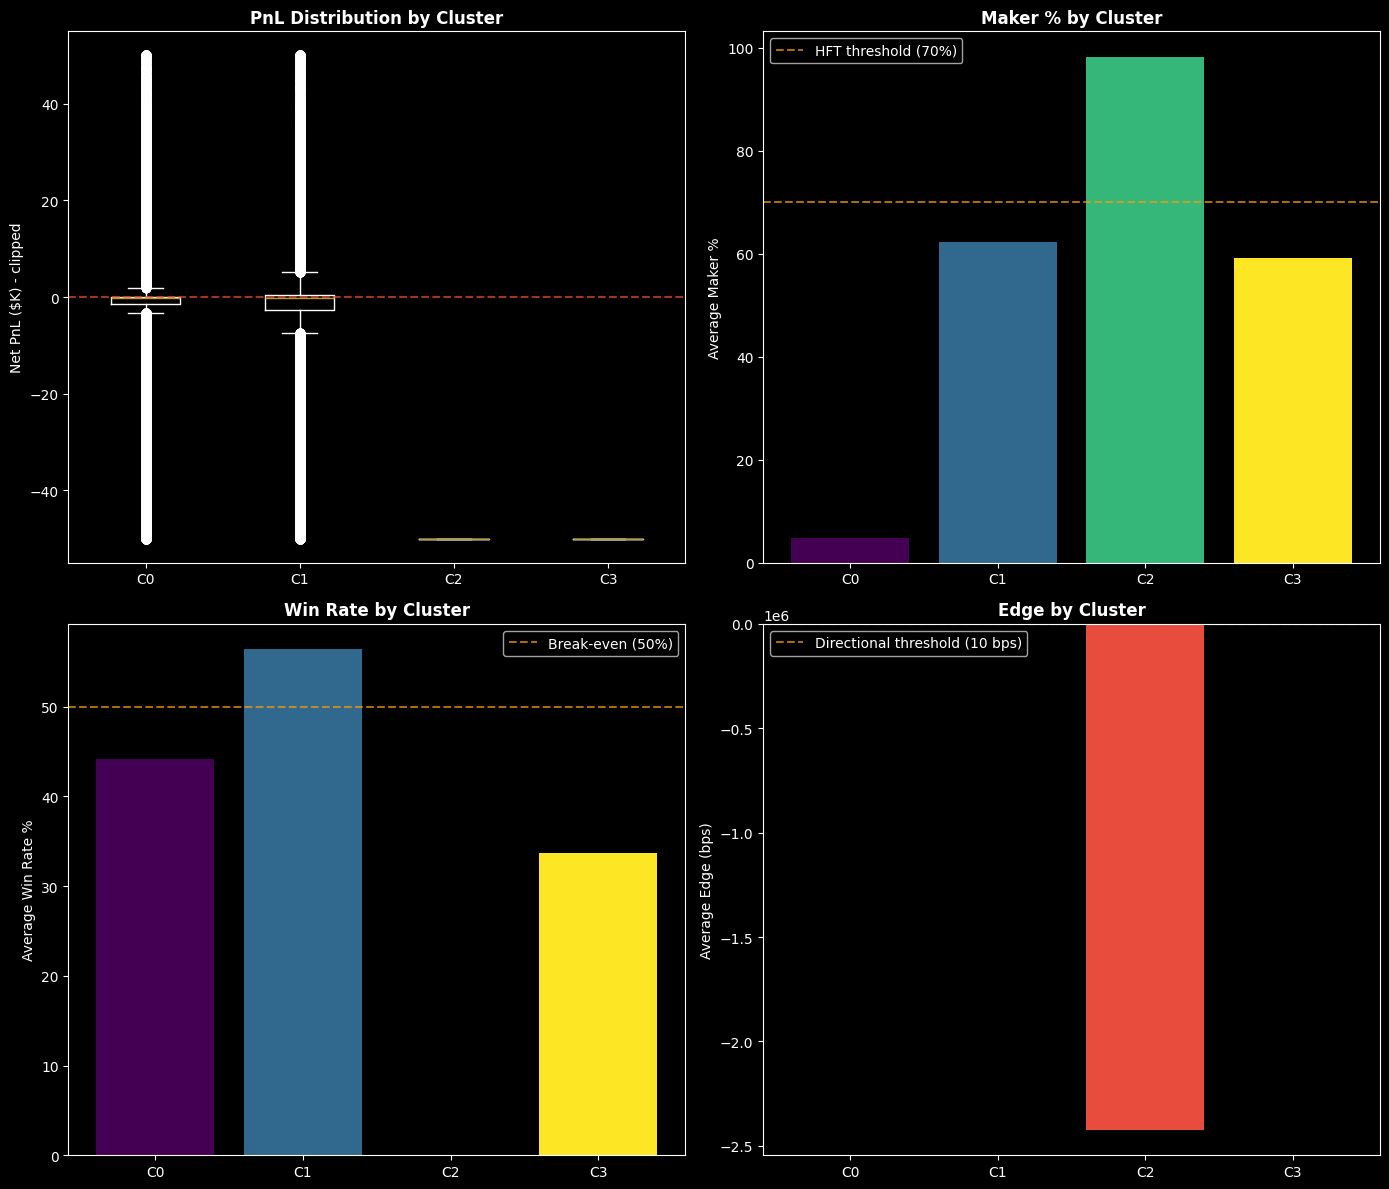

In [83]:
# Visualization: Cluster Characteristics Comparison
if len(cluster_data) >= 20 and 'cluster_data_with_labels' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Box plot: PnL by cluster
    cluster_pnl = {}
    for c in range(optimal_k):
        subset = cluster_data_with_labels.filter(pl.col('cluster') == c)
        pnl_values = [float(p)/1000 for p in subset['net_pnl'].to_list()]
        # Clip to reasonable range for visualization
        pnl_values = [max(-50, min(50, p)) for p in pnl_values]
        cluster_pnl[f'C{c}'] = pnl_values
    
    axes[0, 0].boxplot(cluster_pnl.values(), labels=cluster_pnl.keys())
    axes[0, 0].axhline(y=0, color='#e74c3c', linestyle='--', alpha=0.7)
    axes[0, 0].set_ylabel('Net PnL ($K) - clipped')
    axes[0, 0].set_title('PnL Distribution by Cluster', fontsize=12, fontweight='bold')
    
    # Bar chart: Maker % by cluster
    maker_pcts = cluster_profiles['avg_maker_pct'].to_list()
    colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
    axes[0, 1].bar([f'C{i}' for i in range(optimal_k)], maker_pcts, color=colors)
    axes[0, 1].axhline(y=70, color='#f39c12', linestyle='--', alpha=0.7, label='HFT threshold (70%)')
    axes[0, 1].set_ylabel('Average Maker %')
    axes[0, 1].set_title('Maker % by Cluster', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    
    # Bar chart: Win Rate by cluster
    win_rates = cluster_profiles['avg_win_rate'].to_list()
    axes[1, 0].bar([f'C{i}' for i in range(optimal_k)], win_rates, color=colors)
    axes[1, 0].axhline(y=50, color='#f39c12', linestyle='--', alpha=0.7, label='Break-even (50%)')
    axes[1, 0].set_ylabel('Average Win Rate %')
    axes[1, 0].set_title('Win Rate by Cluster', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    
    # Bar chart: Edge (bps) by cluster
    edges = cluster_profiles['avg_edge_bps'].to_list()
    bar_colors = ['#2ecc71' if e > 0 else '#e74c3c' for e in edges]
    axes[1, 1].bar([f'C{i}' for i in range(optimal_k)], edges, color=bar_colors)
    axes[1, 1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=10, color='#f39c12', linestyle='--', alpha=0.7, label='Directional threshold (10 bps)')
    axes[1, 1].set_ylabel('Average Edge (bps)')
    axes[1, 1].set_title('Edge by Cluster', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

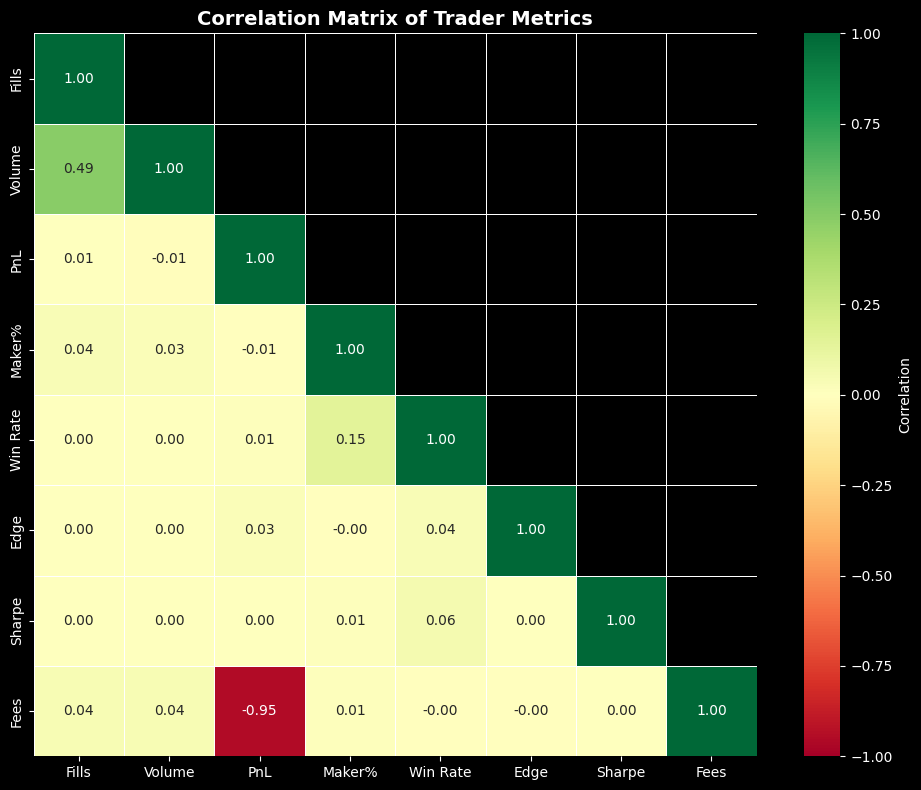


📊 Key Correlations:
   PnL vs Edge:      0.026
   PnL vs Win Rate:  0.009
   PnL vs Maker%:    -0.005
   Volume vs Fees:   0.044
   Edge vs Maker%:   -0.003


In [84]:
# Visualization: Correlation Heatmap of Trader Metrics
corr_data = query("""
    SELECT 
        total_fills as fills,
        total_volume as volume,
        net_pnl as pnl,
        maker_pct,
        win_rate,
        mtm_tv as edge,
        COALESCE(sharpe_ratio, 0) as sharpe,
        fees_paid as fees
    FROM trader_profiles
    WHERE total_volume > 10000
      AND win_rate IS NOT NULL
""")

if len(corr_data) > 10:
    # Convert to pandas for correlation (Polars doesn't have built-in corr)
    import pandas as pd
    
    corr_df = pd.DataFrame({
        'Fills': [float(x) for x in corr_data['fills'].to_list()],
        'Volume': [float(x) for x in corr_data['volume'].to_list()],
        'PnL': [float(x) for x in corr_data['pnl'].to_list()],
        'Maker%': [float(x) for x in corr_data['maker_pct'].to_list()],
        'Win Rate': [float(x) for x in corr_data['win_rate'].to_list()],
        'Edge': [float(x) for x in corr_data['edge'].to_list()],
        'Sharpe': [float(x) for x in corr_data['sharpe'].to_list()],
        'Fees': [float(x) for x in corr_data['fees'].to_list()],
    })
    
    # Compute correlation matrix
    corr_matrix = corr_df.corr()
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlation'}, ax=ax)
    
    ax.set_title('Correlation Matrix of Trader Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Key insights
    print("\n📊 Key Correlations:")
    print(f"   PnL vs Edge:      {corr_matrix.loc['PnL', 'Edge']:.3f}")
    print(f"   PnL vs Win Rate:  {corr_matrix.loc['PnL', 'Win Rate']:.3f}")
    print(f"   PnL vs Maker%:    {corr_matrix.loc['PnL', 'Maker%']:.3f}")
    print(f"   Volume vs Fees:   {corr_matrix.loc['Volume', 'Fees']:.3f}")
    print(f"   Edge vs Maker%:   {corr_matrix.loc['Edge', 'Maker%']:.3f}")

---
## 25. Summary & Key Metrics Dashboard

In [85]:
# Comprehensive summary (using materialized views - no fills table scans)
summary = query("""
    SELECT 
        -- Overall stats from trader_profiles
        (SELECT SUM(total_fills)::bigint FROM trader_profiles) as total_fills,
        (SELECT COUNT(*) FROM trader_profiles) as total_traders,
        (SELECT MAX(unique_coins) FROM trader_profiles) as total_coins,
        (SELECT ROUND(SUM(total_volume)::numeric, 0) FROM trader_profiles) as total_volume,
        
        -- Trader breakdown
        (SELECT COUNT(*) FROM trader_profiles WHERE trader_type = 'SMART_DIRECTIONAL') as smart_traders,
        (SELECT COUNT(*) FROM trader_profiles WHERE trader_type = 'HFT') as hft_traders,
        (SELECT COUNT(*) FROM trader_profiles WHERE trader_type = 'LIQUIDATOR') as liquidators,
        (SELECT COUNT(*) FROM trader_profiles WHERE trader_type = 'RETAIL') as retail_traders,
        
        -- PnL stats
        (SELECT COALESCE(ROUND(SUM(net_pnl)::numeric, 2), 0) FROM trader_profiles WHERE net_pnl > 0) as total_profits,
        (SELECT COALESCE(ROUND(SUM(net_pnl)::numeric, 2), 0) FROM trader_profiles WHERE net_pnl < 0) as total_losses,
        (SELECT COUNT(*) FROM trader_profiles WHERE net_pnl > 0) as profitable_traders,
        (SELECT COUNT(*) FROM trader_profiles WHERE net_pnl <= 0) as losing_traders
""")

print("=" * 60)
print("VIGIL TRADER INTELLIGENCE SUMMARY")
print("=" * 60)
print(f"\n📊 DATA OVERVIEW")
print(f"   Total Fills:    {int(summary['total_fills'][0]):,}")
print(f"   Total Traders:  {int(summary['total_traders'][0]):,}")
print(f"   Total Coins:    {int(summary['total_coins'][0]):,}")
print(f"   Total Volume:   ${float(summary['total_volume'][0]):,.0f}")
print(f"\n👥 TRADER BREAKDOWN")
print(f"   Smart Directional: {int(summary['smart_traders'][0]):,}")
print(f"   HFT:               {int(summary['hft_traders'][0]):,}")
print(f"   Liquidators:       {int(summary['liquidators'][0]):,}")
print(f"   Retail:            {int(summary['retail_traders'][0]):,}")
print(f"\n💰 PNL SUMMARY")
print(f"   Total Profits:     ${float(summary['total_profits'][0]):,.2f}")
print(f"   Total Losses:      ${float(summary['total_losses'][0]):,.2f}")
print(f"   Profitable:        {int(summary['profitable_traders'][0]):,} traders")
print(f"   Losing:            {int(summary['losing_traders'][0]):,} traders")

VIGIL TRADER INTELLIGENCE SUMMARY

📊 DATA OVERVIEW
   Total Fills:    960,561,768
   Total Traders:  467,189
   Total Coins:    189
   Total Volume:   $2,754,713,732,085

👥 TRADER BREAKDOWN
   Smart Directional: 1,773
   HFT:               11,570
   Liquidators:       41,307
   Retail:            412,539

💰 PNL SUMMARY
   Total Profits:     $2,750,179,187.82
   Total Losses:      $-6,311,706,687.36
   Profitable:        109,428 traders
   Losing:            357,761 traders


---
## Key Insights & Signals

### Trader Classification Hierarchy

| Type | Identification | Signal Value |
|------|---------------|--------------|
| **SMART_DIRECTIONAL** | PnL ≥ $100K, Edge ≥ 10bps, Sharpe ≥ 1.0 | Highest - follow their positions |
| **HFT** | Maker ≥ 70%, Edge ≤ 10bps | Low - they profit from spread, not direction |
| **LIQUIDATOR** | Liquidation % ≥ 20% | Low - opportunistic, not predictive |
| **RETAIL** | Everyone else | Counter-signal potential |

### Actionable Signals

1. **Smart Money Confluence**
   - Trigger: Z-score > 1.5 AND L/S ratio > 2x
   - Multiple smart traders on same side = high conviction

2. **Whale Positions**
   - Smart trader opens > $500K position
   - Immediate signal, track the coin

3. **Fresh Wallet Activity**
   - New wallet (< 7 days) with 2x average volume
   - Could be new alpha source or insider

4. **Counter-Trading Retail**
   - Extreme retail positioning (> 80% one side)
   - Consider opposite position

### Key Metrics Reference

| Metric | Formula | Good Value |
|--------|---------|------------|
| **MTM/TV (Edge)** | PnL / Volume | > 10 bps = directional |
| **Sharpe Ratio** | Mean(DailyPnL) / Std(DailyPnL) × √365 | > 2.0 excellent |
| **Profit Factor** | Gross Wins / Gross Losses | > 1.5 solid |
| **Win Rate** | Winning Trades / Total Trades | > 50% good |
| **Maker %** | Maker Fills / Total Fills | > 70% = MM |

### Risk Indicators

1. **Liquidation Spikes**: High liquidation volume = market stress
2. **Smart Money Exit**: Smart traders closing positions rapidly
3. **Volume Anomalies**: Unusual volume without price movement
4. **Fee Destruction**: Traders paying more in fees than PnL